In [147]:
%pip install yfinance
%pip install arch
%pip install arch
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [148]:
# Import relevant libraries
import yfinance as yf

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random

# Time Series Analysis Library: AR,VAR,ARMA; ACF&PACF
import statsmodels.tsa as tsa

# Plotting Library
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Use the lzip to pretty-print short descriptions for the test returns
from statsmodels.compat import lzip

# Import acf & pacf plotting functions 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch, acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson

# Import ARCH
from arch import arch_model

# Plotting set
%matplotlib inline
sns.set_style('darkgrid')

from datetime import datetime, timedelta

from statsmodels.tsa.stattools import adfuller, kpss


In [149]:
#Importing tickers from yfinance
tickers = {'gold': 'GC=F', 'silver': 'SI=F', 'platinum': 'PL=F', 'palladium': 'PA=F'}

In [150]:
# Last 10 years
end_date = datetime.today()
start_date = end_date - timedelta(days=10*365)

In [151]:
data = yf.download(
    list(tickers.values()),
    start=start_date.strftime("%Y-%m-%d"),
    end=end_date.strftime("%Y-%m-%d"),
    progress=True
)

inverse_tickers = {v: k for k, v in tickers.items()}

# Antrophic CLAUDE was used to help generate the code above removing the need for a CSV file and inversing tickers.
# Accessed Date: December 15, 2025


# Extract Close prices and rename columns
prices = data['Close'].copy()
prices = prices.rename(columns=inverse_tickers)

# Drop rows with all NaN
prices = prices.dropna(how='all')

/var/folders/h5/p6vdg3ps6wn1kgd_w454mf500000gn/T/ipykernel_9154/3470426694.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  4 of 4 completed


In [152]:
prices.head()

Ticker,gold,palladium,platinum,silver
Date,,,,
2015-12-21,1081.900024,552.750000,881.099976,14.301
2015-12-22,1074.800049,554.900024,872.799988,14.302
2015-12-23,1069.400024,553.450012,867.900024,14.277
2015-12-24,1077.199951,559.500000,883.400024,14.369
2015-12-28,1070.500000,552.000000,880.000000,13.873


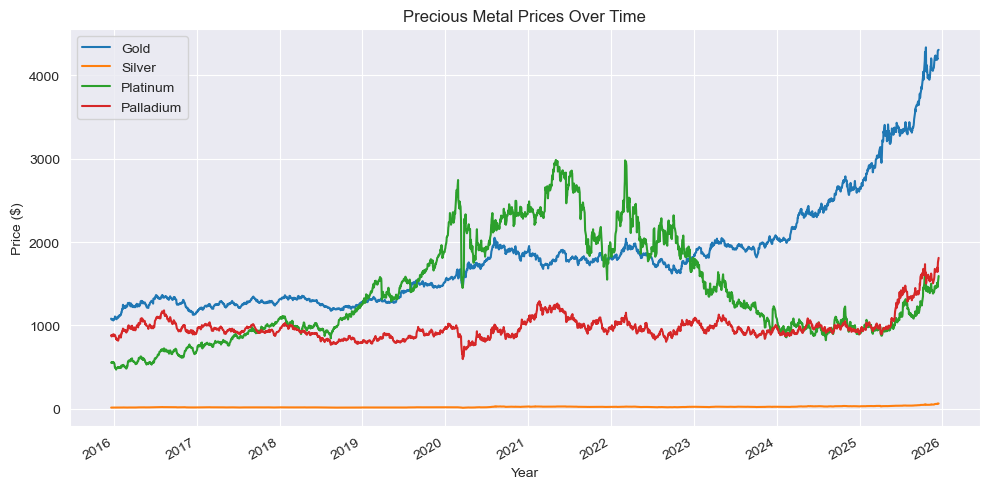

In [153]:
# Plot Price of Metals over Times
prices[['gold', 'silver', 'palladium', 'platinum']].plot(figsize=(10, 5))

plt.title('Precious Metal Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend(['Gold', 'Silver', 'Platinum', 'Palladium'])
plt.tight_layout()
plt.show()

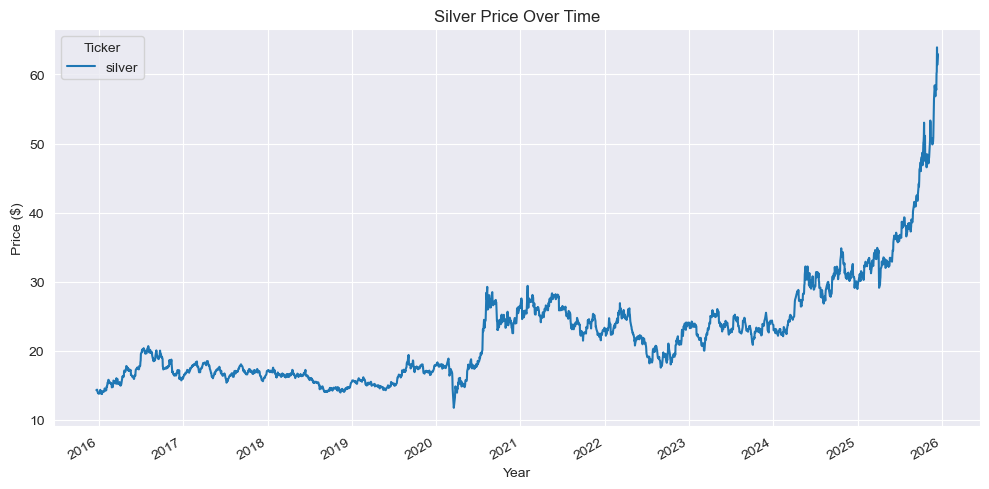

In [154]:
# Silver Price alone due to the small scale compared to other metals
prices[['silver']].plot(figsize=(10, 5))
plt.title('Silver Price Over Time')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.tight_layout()
plt.show()

In [155]:
other_tickers = {'vix': '^VIX','us2y_yield': '^IRX','usd_index': 'DX-Y.NYB', 
                 'us10y_yield': '^TNX', 'wti_oil': 'CL=F'}


In [156]:
# Download data of other info for regression
other_data = yf.download(
    list(other_tickers.values()),
    start=start_date.strftime("%Y-%m-%d"),
    end=end_date.strftime("%Y-%m-%d"),
    progress=True
)

inverse_other_tickers = {v: k for k, v in other_tickers.items()}

# Extract Close prices and rename columns
df1 = other_data["Close"].copy()
df1 = df1.rename(columns=inverse_other_tickers)

# Drop rows with all NaN
df1 = df1.dropna(how="all")

/var/folders/h5/p6vdg3ps6wn1kgd_w454mf500000gn/T/ipykernel_9154/454246658.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  other_data = yf.download(
[*********************100%***********************]  5 of 5 completed


In [157]:
df1.head()

Ticker,wti_oil,usd_index,us2y_yield,us10y_yield,vix
Date,,,,,
2015-12-21,34.740002,98.459999,0.153,2.197,18.700001
2015-12-22,36.139999,98.239998,0.193,2.239,16.600000
2015-12-23,37.500000,98.339996,0.190,2.264,15.570000
2015-12-24,38.099998,97.980003,0.183,2.243,15.740000
2015-12-28,36.810001,97.919998,0.190,2.225,16.910000


In [158]:
# Combining tables together using an inner join on dates
df = prices.join(df1, how='inner')

In [159]:
df.head()

Ticker,gold,palladium,platinum,silver,wti_oil,usd_index,us2y_yield,us10y_yield,vix
Date,,,,,,,,,
2015-12-21,1081.900024,552.750000,881.099976,14.301,34.740002,98.459999,0.153,2.197,18.700001
2015-12-22,1074.800049,554.900024,872.799988,14.302,36.139999,98.239998,0.193,2.239,16.600000
2015-12-23,1069.400024,553.450012,867.900024,14.277,37.500000,98.339996,0.190,2.264,15.570000
2015-12-24,1077.199951,559.500000,883.400024,14.369,38.099998,97.980003,0.183,2.243,15.740000
2015-12-28,1070.500000,552.000000,880.000000,13.873,36.810001,97.919998,0.190,2.225,16.910000


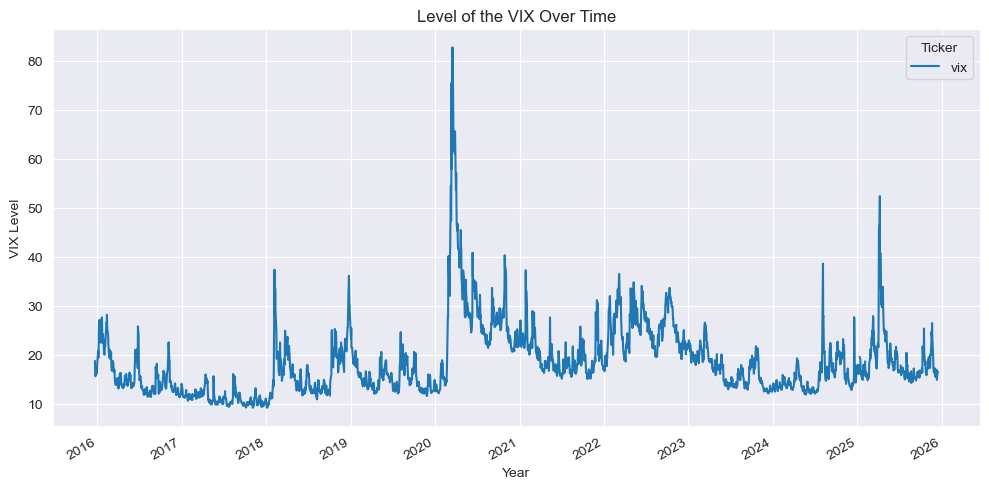

In [160]:
# Level of the VIX over time 
df[['vix']].plot(figsize=(10, 5))
plt.title('Level of the VIX Over Time')
plt.xlabel('Year')
plt.ylabel('VIX Level')
plt.tight_layout()
plt.show()

In [161]:
# Calculating log daily log returns for metals, VIX, WTI & USD Index
metals = ['gold', 'silver', 'platinum', 'palladium']

for metal in metals:
    df[f'{metal}_lr'] = (np.log(df[metal] / df[metal].shift(1)))

df['vix_lr'] = np.log(df['vix'] / df['vix'].shift(1))
df['usd_index_lr'] = np.log(df['usd_index'] / df['usd_index'].shift(1))
df['wti_oil_lr'] = np.log(df['wti_oil'] / df['wti_oil'].shift(1))

# Change in the two yields
df['us10y_yield_change'] = df['us10y_yield'] - df['us10y_yield'].shift(1)
df['us2y_yield_change'] = df['us2y_yield'] - df['us2y_yield'].shift(1)

In [162]:
df.head()

Ticker,gold,palladium,platinum,silver,wti_oil,usd_index,us2y_yield,us10y_yield,vix,gold_lr,silver_lr,platinum_lr,palladium_lr,vix_lr,usd_index_lr,wti_oil_lr,us10y_yield_change,us2y_yield_change
Date,,,,,,,,,,,,,,,,,,
2015-12-21,1081.900024,552.750000,881.099976,14.301,34.740002,98.459999,0.153,2.197,18.700001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-22,1074.800049,554.900024,872.799988,14.302,36.139999,98.239998,0.193,2.239,16.600000,-0.006584,0.000070,-0.009465,0.003882,-0.119121,-0.002237,0.039508,0.042,0.040
2015-12-23,1069.400024,553.450012,867.900024,14.277,37.500000,98.339996,0.190,2.264,15.570000,-0.005037,-0.001750,-0.005630,-0.002617,-0.064057,0.001017,0.036941,0.025,-0.003
2015-12-24,1077.199951,559.500000,883.400024,14.369,38.099998,97.980003,0.183,2.243,15.740000,0.007267,0.006423,0.017702,0.010872,0.010859,-0.003667,0.015873,-0.021,-0.007
2015-12-28,1070.500000,552.000000,880.000000,13.873,36.810001,97.919998,0.190,2.225,16.910000,-0.006239,-0.035129,-0.003856,-0.013495,0.071700,-0.000613,-0.034445,-0.018,0.007


In [163]:
df.tail()

Ticker,gold,palladium,platinum,silver,wti_oil,usd_index,us2y_yield,us10y_yield,vix,gold_lr,silver_lr,platinum_lr,palladium_lr,vix_lr,usd_index_lr,wti_oil_lr,us10y_yield_change,us2y_yield_change
Date,,,,,,,,,,,,,,,,,,
2025-12-09,4206.700195,1511.400024,1695.099976,60.168999,58.250000,99.220001,3.632,4.186,16.93,0.004646,0.040532,0.023941,0.018565,0.016077,0.001311,-0.010757,0.014,0.014
2025-12-10,4196.399902,1458.300049,1641.800049,60.379002,58.459999,98.790001,3.593,4.164,15.77,-0.002452,0.003484,-0.031948,-0.035765,-0.070978,-0.004343,0.003599,-0.022,-0.039
2025-12-11,4285.500000,1512.699951,1707.800049,63.929001,57.599998,98.349998,3.568,4.141,14.85,0.021010,0.057132,0.039413,0.036625,-0.060110,-0.004464,-0.014820,-0.023,-0.025
2025-12-12,4300.100098,1514.199951,1757.099976,61.362000,57.439999,98.400002,3.525,4.194,15.74,0.003401,-0.040982,0.028459,0.000991,0.058205,0.000508,-0.002782,0.053,-0.043
2025-12-15,4306.700195,1592.800049,1810.500000,62.939999,56.820000,98.309998,3.538,4.182,16.50,0.001534,0.025391,0.029938,0.050606,0.047155,-0.000915,-0.010853,-0.012,0.013


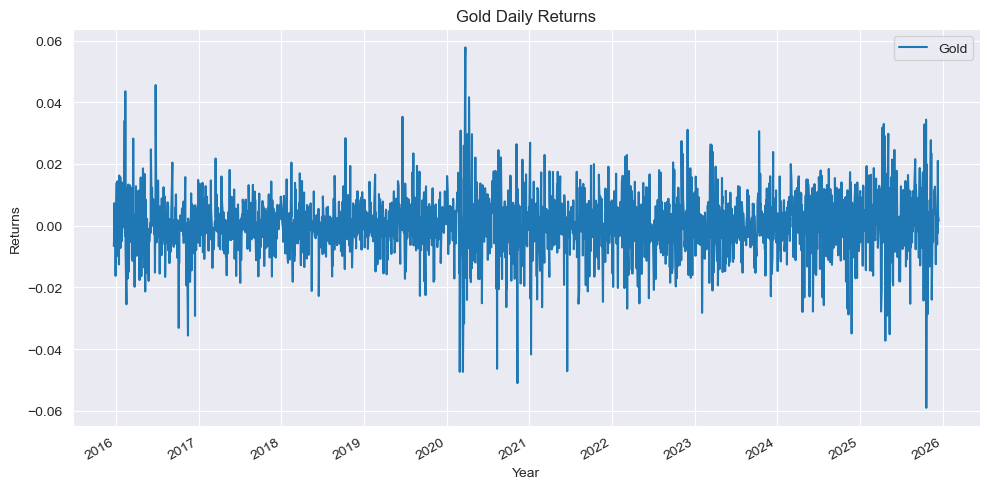

In [164]:
# Plot Price of Metals over Times
df['gold_lr'].plot(figsize=(10, 5))

plt.title('Gold Daily Returns')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.legend(['Gold'])
plt.tight_layout()
plt.show()

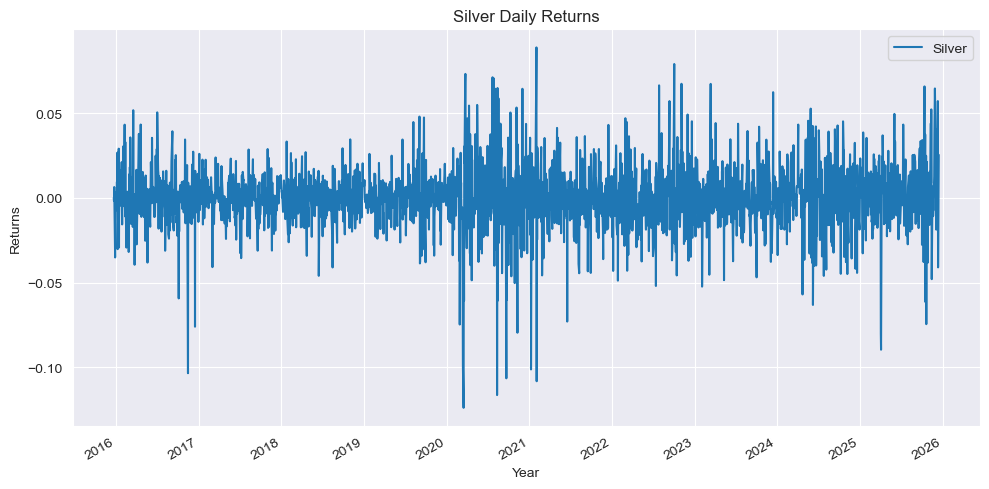

In [165]:
# Plot Price of Metals over Times
df['silver_lr'].plot(figsize=(10, 5))

plt.title('Silver Daily Returns')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.legend(['Silver'])
plt.tight_layout()
plt.show()

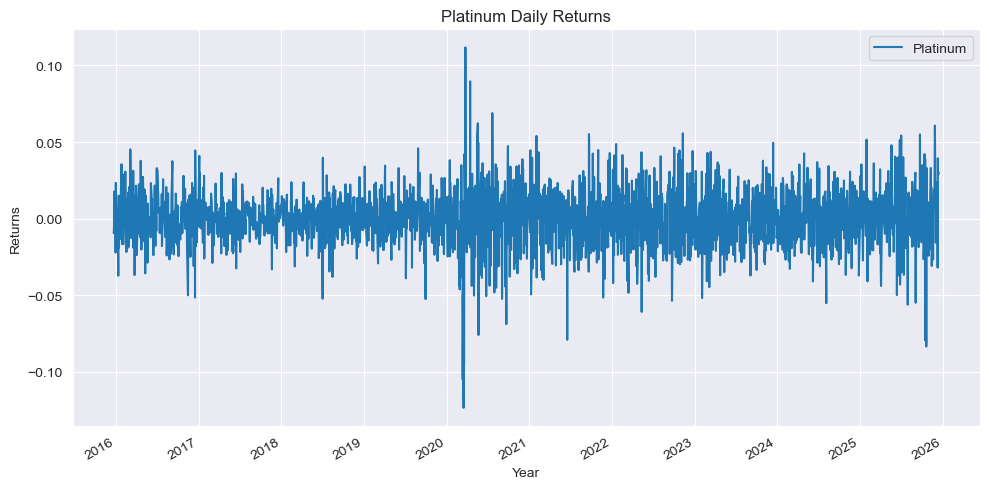

In [166]:
# Plot Price of Metals over Times
df['platinum_lr'].plot(figsize=(10, 5))

plt.title('Platinum Daily Returns')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.legend(['Platinum'])
plt.tight_layout()
plt.show()

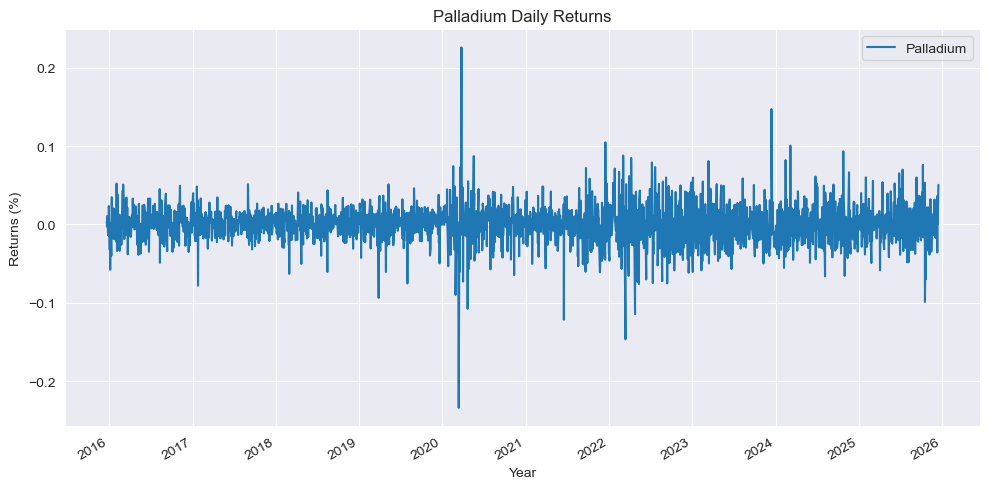

In [167]:
# Plot Price of Metals over Times
df['palladium_lr'].plot(figsize=(10, 5))

plt.title('Palladium Daily Returns')
plt.xlabel('Year')
plt.ylabel('Returns (%)')
plt.legend(['Palladium'])
plt.tight_layout()
plt.show()

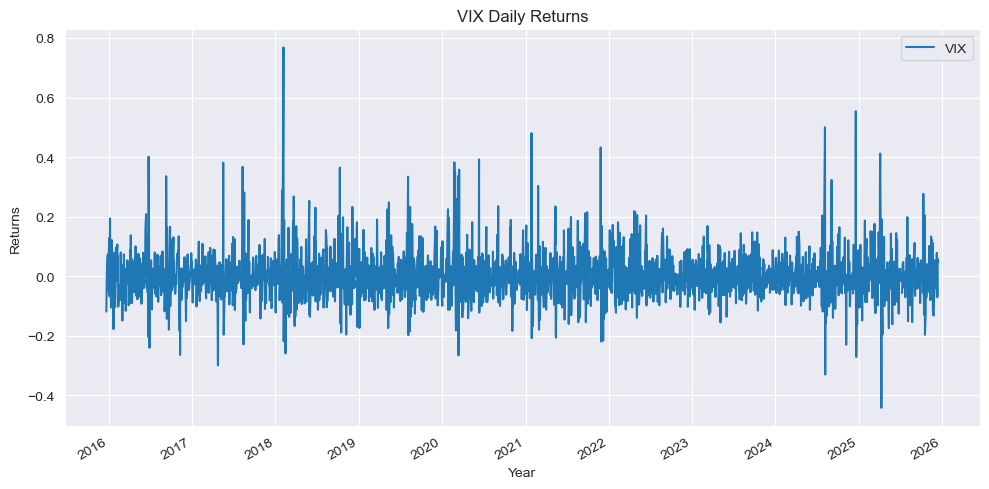

In [168]:
# Plotting the VIX Daily Returns
df['vix_lr'].plot(figsize=(10, 5))
plt.title('VIX Daily Returns')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.legend(['VIX'])
plt.tight_layout()
plt.show()

In [169]:
# Getting a correlation matrix of the variables

# Select only return columns
returns_df = df.filter(regex='_lr$|_change$')
# Line from CLAUDE to get the most effective way to get just the returns - Accessed 15 December 2025

# Correlation of that data
corr_matrix = returns_df.corr()
print(corr_matrix)

# Adapted from undergraduate assignment Rory Mulhern - Accessed 15 December 2025
# Link https://github.com/rorymul/ml_assignment/blob/main/Data%20Analytics%20Assignment%20vF.ipynb

Ticker               gold_lr  silver_lr  platinum_lr  palladium_lr    vix_lr  \
Ticker                                                                         
gold_lr             1.000000   0.762659     0.545618      0.351412  0.029028   
silver_lr           0.762659   1.000000     0.640032      0.445504 -0.092591   
platinum_lr         0.545618   0.640032     1.000000      0.562771 -0.169422   
palladium_lr        0.351412   0.445504     0.562771      1.000000 -0.141088   
vix_lr              0.029028  -0.092591    -0.169422     -0.141088  1.000000   
usd_index_lr       -0.411941  -0.359410    -0.351845     -0.248204  0.061369   
wti_oil_lr          0.096673   0.169143     0.196624      0.194603 -0.195649   
us10y_yield_change -0.305158  -0.157247    -0.077672     -0.042442 -0.143868   
us2y_yield_change  -0.102216  -0.052946    -0.030862     -0.027923 -0.042333   

Ticker              usd_index_lr  wti_oil_lr  us10y_yield_change  \
Ticker                                             

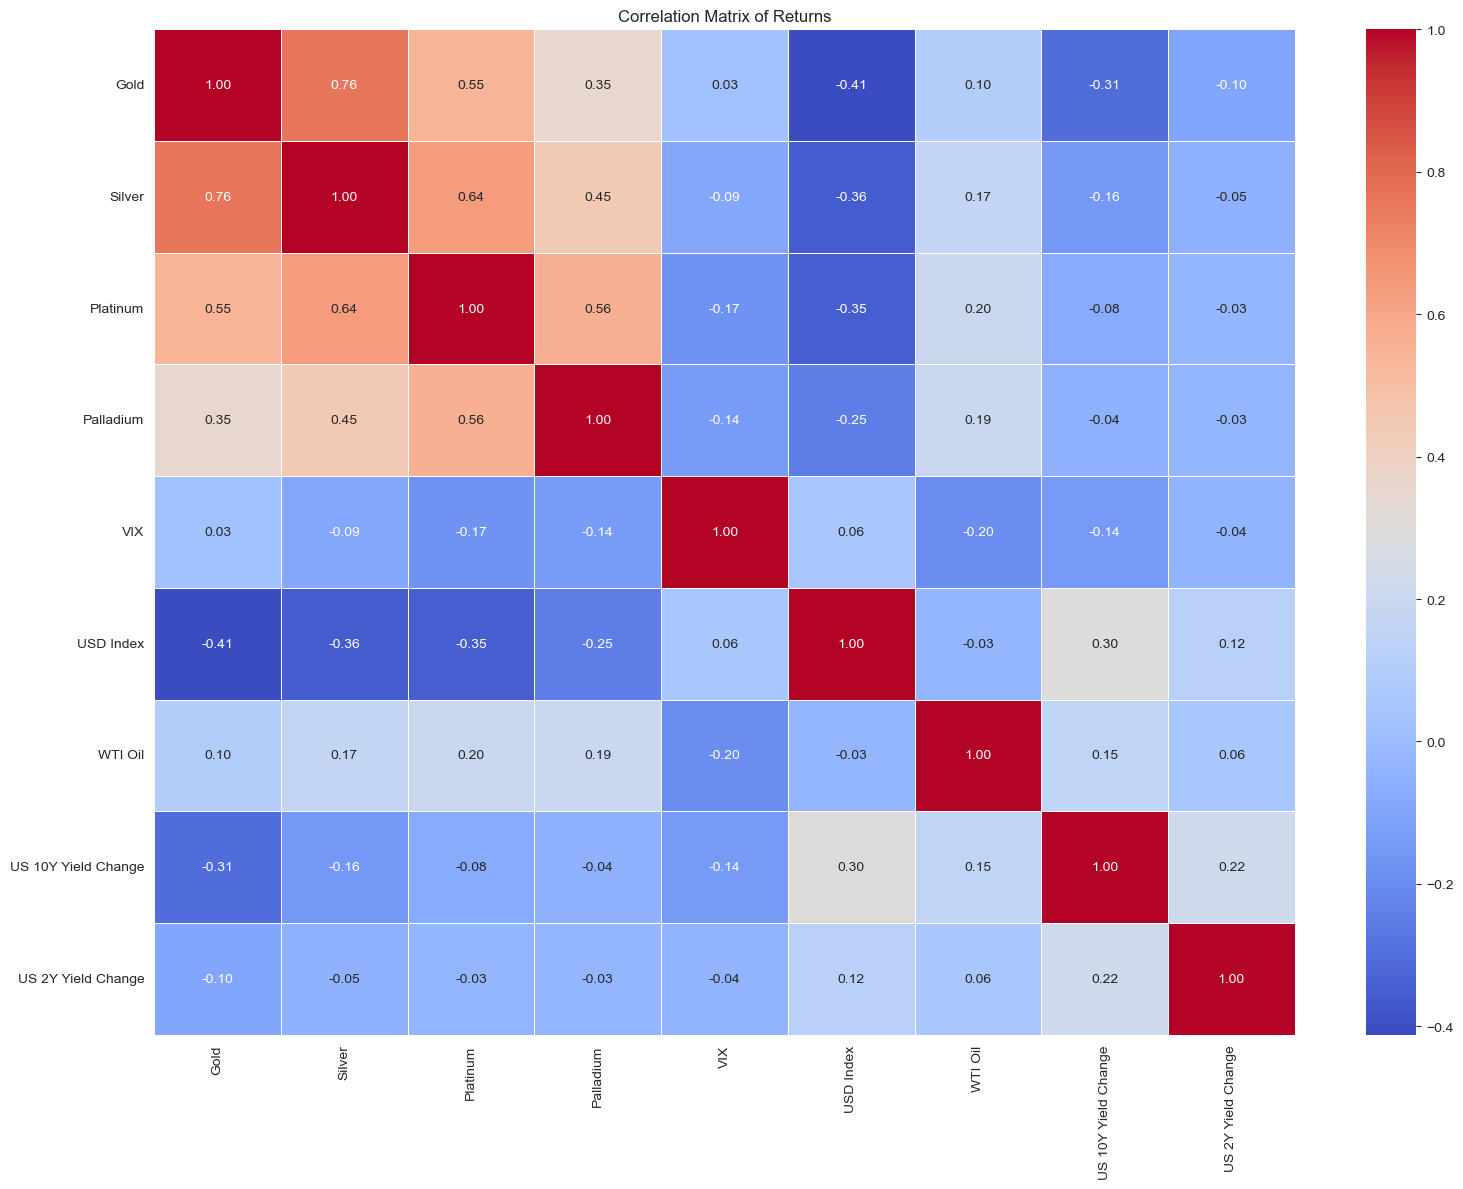

In [170]:
# Visual the Correlation Matrix
label_map = {
    'gold_lr': 'Gold',
    'silver_lr': 'Silver',
    'platinum_lr': 'Platinum',
    'palladium_lr': 'Palladium',
    'vix_lr': 'VIX',
    'usd_index_lr': 'USD Index',
    'wti_oil_lr': 'WTI Oil',
    'us10y_yield_change': 'US 10Y Yield Change',
    'us2y_yield_change': 'US 2Y Yield Change'
}

corr_matrix_named = corr_matrix.rename(
    index=label_map,
    columns=label_map
)

corr_matrix_named.index.name = None
corr_matrix_named.columns.name = None

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix_named,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title('Correlation Matrix of Returns')
plt.tight_layout()
plt.show()


# Adapted from undergraduate assignment Rory Mulhern - Accessed 15 December 2025
# Link https://github.com/rorymul/ml_assignment/blob/main/Data%20Analytics%20Assignment%20vF.ipynb

In [171]:
# Code below adpated from CLAUDE to see if the variables are stationary
# Accessed Date: December 15, 2025

In [172]:
# ADF test for log Gold price (with constant and trend)
gold_adf_result = adfuller(df["gold_lr"].dropna(), autolag="AIC", regression="ct")
print("ADF Test: Log Gold Price")
print(f"  Test Statistic: {gold_adf_result[0]:.4f}")
print(f"  p-value: {gold_adf_result[1]:.4f}")
print(f"  Critical Values: {gold_adf_result[4]}")

if gold_adf_result[1] < 0.05:
        print("\nSTATIONARY (reject H0: unit root)")
else:
        print("\nNON-STATIONARY (fail to reject H0)")

ADF Test: Log Gold Price
  Test Statistic: -51.5818
  p-value: 0.0000
  Critical Values: {'1%': -3.9623842170080987, '5%': -3.4122419976413125, '10%': -3.1280815664075035}

STATIONARY (reject H0: unit root)


In [173]:
# KPSS test for log Gold price (with trend)
gold_kpss_result = kpss(df["gold_lr"].dropna(), regression="ct", nlags="auto")
print("\nKPSS Test: Log Gold Price")
print(f"  Test Statistic: {gold_kpss_result[0]:.4f}")
print(f"  p-value: {gold_kpss_result[1]:.4f}")
print(f"  Critical Values: {gold_kpss_result[3]}")

if gold_kpss_result[1] < 0.05:
        print("\n NON-STATIONARY (reject H0: stationarity)")
else:
      print("\n STATIONARY (fail to reject H0)")


KPSS Test: Log Gold Price
  Test Statistic: 0.1058
  p-value: 0.1000
  Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}

 STATIONARY (fail to reject H0)


/var/folders/h5/p6vdg3ps6wn1kgd_w454mf500000gn/T/ipykernel_9154/2058628035.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  gold_kpss_result = kpss(df["gold_lr"].dropna(), regression="ct", nlags="auto")


In [174]:
# ADF test for log Silver price (with constant and trend)
silver_adf_result = adfuller(df["silver_lr"].dropna(), autolag="AIC", regression="ct")
print("ADF Test: Log Silver Price")
print(f"  Test Statistic: {silver_adf_result[0]:.4f}")
print(f"  p-value: {silver_adf_result[1]:.4f}")
print(f"  Critical Values: {silver_adf_result[4]}")

if silver_adf_result[1] < 0.05:
        print("\nSTATIONARY (reject H0: unit root)")
else:
        print("\nNON-STATIONARY (fail to reject H0)")

ADF Test: Log Silver Price
  Test Statistic: -33.8062
  p-value: 0.0000
  Critical Values: {'1%': -3.9623856604685446, '5%': -3.4122426970591513, '10%': -3.1280819781320726}

STATIONARY (reject H0: unit root)


In [175]:
# KPSS test for log Silver price (with constant)
silver_kpss_result = kpss(df["silver_lr"].dropna(), regression="c", nlags="auto")
print("\nKPSS Test: Log Gold Price")
print(f"  Test Statistic: {silver_kpss_result[0]:.4f}")
print(f"  p-value: {silver_kpss_result[1]:.4f}")
print(f"  Critical Values: {silver_kpss_result[3]}")

if silver_kpss_result[1] < 0.05:
        print("\n NON-STATIONARY (reject H0: stationarity)")
else:
      print("\n STATIONARY (fail to reject H0)")


KPSS Test: Log Gold Price
  Test Statistic: 0.2057
  p-value: 0.1000
  Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

 STATIONARY (fail to reject H0)


/var/folders/h5/p6vdg3ps6wn1kgd_w454mf500000gn/T/ipykernel_9154/2998019960.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  silver_kpss_result = kpss(df["silver_lr"].dropna(), regression="c", nlags="auto")


In [176]:
# ADF test for log platinum price (with constant and trend)
platinum_adf_result = adfuller(df["platinum_lr"].dropna(), autolag="AIC", regression="ct")
print("ADF Test: Log Platinum Price")       
print(f"  Test Statistic: {platinum_adf_result[0]:.4f}")
print(f"  p-value: {platinum_adf_result[1]:.4f}")
print(f"  Critical Values: {platinum_adf_result[4]}")

if platinum_adf_result[1] < 0.05:
        print("\nSTATIONARY (reject H0: unit root)")
else:
        print("\nNON-STATIONARY (fail to reject H0)")

ADF Test: Log Platinum Price
  Test Statistic: -20.5658
  p-value: 0.0000
  Critical Values: {'1%': -3.96239724979283, '5%': -3.4122483125698237, '10%': -3.1280852837982867}

STATIONARY (reject H0: unit root)


In [177]:
# KPSS test for log Platinum price (with constant)
platinum_kpss_result = kpss(df["platinum_lr"].dropna(), regression="c", nlags="auto")
print("\nKPSS Test: Log Platinum Price")
print(f"  Test Statistic: {platinum_kpss_result[0]:.4f}")
print(f"  p-value: {platinum_kpss_result[1]:.4f}")
print(f"  Critical Values: {platinum_kpss_result[3]}")


KPSS Test: Log Platinum Price
  Test Statistic: 0.1598
  p-value: 0.1000
  Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/h5/p6vdg3ps6wn1kgd_w454mf500000gn/T/ipykernel_9154/4012902219.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  platinum_kpss_result = kpss(df["platinum_lr"].dropna(), regression="c", nlags="auto")


In [178]:
# ADF test for log palladium price (with constant and trend)
palladium_adf_result = adfuller(df["palladium_lr"].dropna(), autolag="AIC", regression="ct")
print("ADF Test: Log Palladium Price")
print(f"  Test Statistic: {palladium_adf_result[0]:.4f}")
print(f"  p-value: {palladium_adf_result[1]:.4f}")
print(f"  Critical Values: {palladium_adf_result[4]}")

if palladium_adf_result[1] < 0.05:
        print("\nSTATIONARY (reject H0: unit root)")
else:
        print("\nNON-STATIONARY (fail to reject H0)")

ADF Test: Log Palladium Price
  Test Statistic: -11.2751
  p-value: 0.0000
  Critical Values: {'1%': -3.962425074482108, '5%': -3.4122617947281424, '10%': -3.1280932202822895}

STATIONARY (reject H0: unit root)


In [179]:
# KPSS test for log palladium price (with constant)
palladium_kpss_result = kpss(df["palladium_lr"].dropna(), regression="c", nlags="auto")
print("\nKPSS Test: Log Palladium Price")
print(f"  Test Statistic: {palladium_kpss_result[0]:.4f}")
print(f"  p-value: {palladium_kpss_result[1]:.4f}")
print(f"  Critical Values: {palladium_kpss_result[3]}")


KPSS Test: Log Palladium Price
  Test Statistic: 0.1721
  p-value: 0.1000
  Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/h5/p6vdg3ps6wn1kgd_w454mf500000gn/T/ipykernel_9154/4014965614.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  palladium_kpss_result = kpss(df["palladium_lr"].dropna(), regression="c", nlags="auto")


In [180]:
# ADF test for log VIX price (with constant and trend)
vix_adf_result = adfuller(df["vix_lr"].dropna(), autolag="AIC", regression="ct")
print("ADF Test: Log VIX Price")
print(f"  Test Statistic: {vix_adf_result[0]:.4f}")
print(f"  p-value: {vix_adf_result[1]:.4f}")
print(f"  Critical Values: {vix_adf_result[4]}") 

if vix_adf_result[1] < 0.05:
        print("\nSTATIONARY (reject H0: unit root)")
else:
        print("\nNON-STATIONARY (fail to reject H0)")

ADF Test: Log VIX Price
  Test Statistic: -20.9811
  p-value: 0.0000
  Critical Values: {'1%': -3.962400158741787, '5%': -3.4122497220744035, '10%': -3.1280861135265012}

STATIONARY (reject H0: unit root)


In [181]:
# KPSS test for log VIX price (with constant)
vix_kpss_result = kpss(df["vix_lr"].dropna(), regression="c", nlags="auto")
print("\nKPSS Test: Log VIX Price")
print(f"  Test Statistic: {vix_kpss_result[0]:.4f}")
print(f"  p-value: {vix_kpss_result[1]:.4f}")
print(f"  Critical Values: {vix_kpss_result[3]}")


KPSS Test: Log VIX Price
  Test Statistic: 0.0156
  p-value: 0.1000
  Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/h5/p6vdg3ps6wn1kgd_w454mf500000gn/T/ipykernel_9154/603570498.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  vix_kpss_result = kpss(df["vix_lr"].dropna(), regression="c", nlags="auto")


In [182]:
# ADF test for log USD Index price (with constant and trend)
usdi_adf_result = adfuller(df["usd_index_lr"].dropna(), autolag="AIC", regression="ct")
print("ADF Test: Log USD Index Price")
print(f"  Test Statistic: {usdi_adf_result[0]:.4f}")
print(f"  p-value: {usdi_adf_result[1]:.4f}")
print(f"  Critical Values: {usdi_adf_result[4]}")

if usdi_adf_result[1] < 0.05:
        print("\nSTATIONARY (reject H0: unit root)")
else:
        print("\nNON-STATIONARY (fail to reject H0)")

ADF Test: Log USD Index Price
  Test Statistic: -21.8475
  p-value: 0.0000
  Critical Values: {'1%': -3.9623943455021897, '5%': -3.4122469053214126, '10%': -3.128084455397916}

STATIONARY (reject H0: unit root)


In [183]:
# KPSS test for log USD Index price (with constant)
usdi_kpss_result = kpss(df["usd_index_lr"].dropna(), regression="c", nlags="auto")
print("\nKPSS Test: Log USD Index Price")
print(f"  Test Statistic: {usdi_kpss_result[0]:.4f}")
print(f"  p-value: {usdi_kpss_result[1]:.4f}")
print(f"  Critical Values: {usdi_kpss_result[3]}")


KPSS Test: Log USD Index Price
  Test Statistic: 0.0578
  p-value: 0.1000
  Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/h5/p6vdg3ps6wn1kgd_w454mf500000gn/T/ipykernel_9154/2926111449.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  usdi_kpss_result = kpss(df["usd_index_lr"].dropna(), regression="c", nlags="auto")


In [184]:
# ADF test for log WTI Oil price (with constant and trend)
oil_adf_result = adfuller(df["wti_oil_lr"].dropna(), autolag="AIC", regression="ct")
print("ADF Test: Log WTI Oil Price")
print(f"  Test Statistic: {oil_adf_result[0]:.4f}")
print(f"  p-value: {oil_adf_result[1]:.4f}")
print(f"  Critical Values: {oil_adf_result[4]}")

if oil_adf_result[1] < 0.05:
        print("\nSTATIONARY (reject H0: unit root)")
else:
        print("\nNON-STATIONARY (fail to reject H0)")

ADF Test: Log WTI Oil Price
  Test Statistic: -9.0455
  p-value: 0.0000
  Critical Values: {'1%': -3.962422125480927, '5%': -3.412260365825113, '10%': -3.128092379137351}

STATIONARY (reject H0: unit root)


In [185]:
# KPSS test for log S&P500 price (with constant)
oil_kpss_result = kpss(df["wti_oil_lr"].dropna(), regression="c", nlags="auto")
print("\nKPSS Test: Log WTI Oil Price")
print(f"  Test Statistic: {oil_kpss_result[0]:.4f}")
print(f"  p-value: {oil_kpss_result[1]:.4f}")
print(f"  Critical Values: {oil_kpss_result[3]}")


KPSS Test: Log WTI Oil Price
  Test Statistic: 0.1154
  p-value: 0.1000
  Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/var/folders/h5/p6vdg3ps6wn1kgd_w454mf500000gn/T/ipykernel_9154/170024516.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  oil_kpss_result = kpss(df["wti_oil_lr"].dropna(), regression="c", nlags="auto")


In [186]:
# Gold vs VIX, USD Index OLS Regression no S&P500 due to high correlation with the VIX
data_gol = df[['gold_lr', 'vix_lr', 'usd_index_lr', 'wti_oil_lr', 'us10y_yield_change', 'us2y_yield_change']].dropna()

In [187]:
# Fit OLS model
model_gold = smf.ols(formula='gold_lr ~ vix_lr + usd_index_lr + wti_oil_lr + us10y_yield_change + us2y_yield_change', data=data_gol).fit()
print(model_gold.summary())

                            OLS Regression Results                            
Dep. Variable:                gold_lr   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     142.7
Date:                Tue, 16 Dec 2025   Prob (F-statistic):          2.00e-133
Time:                        16:35:28   Log-Likelihood:                 8380.4
No. Observations:                2503   AIC:                        -1.675e+04
Df Residuals:                    2497   BIC:                        -1.671e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0006      0

In [188]:
# BG on Gold regression
bg_test = acorr_breusch_godfrey(model_gold, nlags=4)
print("Breusch-Godfrey Test:")
print(f"  Chi-square Statistic: {bg_test[0]}")
print(f"  p-value: {bg_test[1]}")

Breusch-Godfrey Test:
  Chi-square Statistic: 13.274570664505093
  p-value: 0.010009275006311368


In [189]:
# Robust Gold OLS Regression
robust_gold = model_gold.get_robustcov_results(cov_type='HAC', maxlags=4)
print("\nRobust OLS with HAC Standard Errors:")
print(robust_gold.summary())


Robust OLS with HAC Standard Errors:
                            OLS Regression Results                            
Dep. Variable:                gold_lr   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     77.68
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           6.78e-76
Time:                        16:35:28   Log-Likelihood:                 8380.4
No. Observations:                2503   AIC:                        -1.675e+04
Df Residuals:                    2497   BIC:                        -1.671e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [190]:
# Silver vs VIX, USD Index OLS Regression no S&P500 due to high correlation with the VIX
data_sil = df[['silver_lr', 'vix_lr', 'usd_index_lr', 'wti_oil_lr', 'us10y_yield_change', 'us2y_yield_change']].dropna()

In [191]:
# Fit OLS model
model_silver = smf.ols(formula='silver_lr ~ vix_lr + usd_index_lr + wti_oil_lr + us10y_yield_change + us2y_yield_change', data=data_sil).fit()
print(model_silver.summary())

                            OLS Regression Results                            
Dep. Variable:              silver_lr   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     97.71
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           2.87e-94
Time:                        16:35:28   Log-Likelihood:                 6666.6
No. Observations:                2503   AIC:                        -1.332e+04
Df Residuals:                    2497   BIC:                        -1.329e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0006      0

In [192]:
# BG on Silver regression
bg_test = acorr_breusch_godfrey(model_silver, nlags=4)
print("Breusch-Godfrey Test:")
print(f"  Chi-square Statistic: {bg_test[0]}")
print(f"  p-value: {bg_test[1]}")

Breusch-Godfrey Test:
  Chi-square Statistic: 13.76372719130336
  p-value: 0.00808860318049019


In [193]:
# Robust Silver OLS Regression
robust_silver = model_silver.get_robustcov_results(cov_type='HAC', maxlags=4)
print("\nRobust OLS with HAC Standard Errors:")
print(robust_silver.summary())


Robust OLS with HAC Standard Errors:
                            OLS Regression Results                            
Dep. Variable:              silver_lr   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     68.82
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           1.42e-67
Time:                        16:35:29   Log-Likelihood:                 6666.6
No. Observations:                2503   AIC:                        -1.332e+04
Df Residuals:                    2497   BIC:                        -1.329e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [194]:
# Platinum vs VIX, USD Index OLS Regression no S&P500 due to high correlation with the VIX
data_plat = df[['platinum_lr', 'vix_lr', 'usd_index_lr', 'wti_oil_lr', 'us10y_yield_change', 'us2y_yield_change']].dropna()

In [195]:
# Fit OLS model
model_platinum = smf.ols(formula='platinum_lr ~ vix_lr + usd_index_lr + wti_oil_lr + us10y_yield_change + us2y_yield_change', data=data_plat).fit()
print(model_platinum.summary())

                            OLS Regression Results                            
Dep. Variable:            platinum_lr   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     103.7
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           1.18e-99
Time:                        16:35:29   Log-Likelihood:                 6738.7
No. Observations:                2501   AIC:                        -1.347e+04
Df Residuals:                    2495   BIC:                        -1.343e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0002      0

In [196]:
# BG on Platinum regression
bg_test = acorr_breusch_godfrey(model_platinum, nlags=4)
print("Breusch-Godfrey Test:")
print(f"  Chi-square Statistic: {bg_test[0]}")
print(f"  p-value: {bg_test[1]}")

Breusch-Godfrey Test:
  Chi-square Statistic: 10.989886891591349
  p-value: 0.026677907166256867


In [197]:
# Robust Platinum OLS Regression
robust_platinum = model_platinum.get_robustcov_results(cov_type='HAC', maxlags=4)
print("\nRobust OLS with HAC Standard Errors:")
print(robust_platinum.summary())


Robust OLS with HAC Standard Errors:
                            OLS Regression Results                            
Dep. Variable:            platinum_lr   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     75.98
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           2.65e-74
Time:                        16:35:29   Log-Likelihood:                 6738.7
No. Observations:                2501   AIC:                        -1.347e+04
Df Residuals:                    2495   BIC:                        -1.343e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [198]:
# Palladium vs VIX, USD Index OLS Regression no S&P500 due to high correlation with the VIX
data_pall = df[['palladium_lr', 'vix_lr', 'usd_index_lr', 'wti_oil_lr', 'us10y_yield_change', 'us2y_yield_change']].dropna()

In [199]:
# Fit OLS model
model_palladium = smf.ols(formula='palladium_lr ~ vix_lr + usd_index_lr + wti_oil_lr + us10y_yield_change + us2y_yield_change', data=data_pall).fit()
print(model_palladium.summary())

                            OLS Regression Results                            
Dep. Variable:           palladium_lr   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     58.68
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           6.65e-58
Time:                        16:35:29   Log-Likelihood:                 5872.3
No. Observations:                2501   AIC:                        -1.173e+04
Df Residuals:                    2495   BIC:                        -1.170e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0004      0

In [200]:
# BG on Palladium regression
bg_test = acorr_breusch_godfrey(model_palladium, nlags=4)
print("Breusch-Godfrey Test:")
print(f"  Chi-square Statistic: {bg_test[0]}")
print(f"  p-value: {bg_test[1]}")

Breusch-Godfrey Test:
  Chi-square Statistic: 6.988160387624061
  p-value: 0.13651521906805872


In [201]:
# Robust Palladium OLS Regression
robust_palladium = model_palladium.get_robustcov_results(cov_type='HAC', maxlags=4)
print("\nRobust OLS with HAC Standard Errors:")
print(robust_palladium.summary())


Robust OLS with HAC Standard Errors:
                            OLS Regression Results                            
Dep. Variable:           palladium_lr   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     42.10
Date:                Tue, 16 Dec 2025   Prob (F-statistic):           9.58e-42
Time:                        16:35:29   Log-Likelihood:                 5872.3
No. Observations:                2501   AIC:                        -1.173e+04
Df Residuals:                    2495   BIC:                        -1.170e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

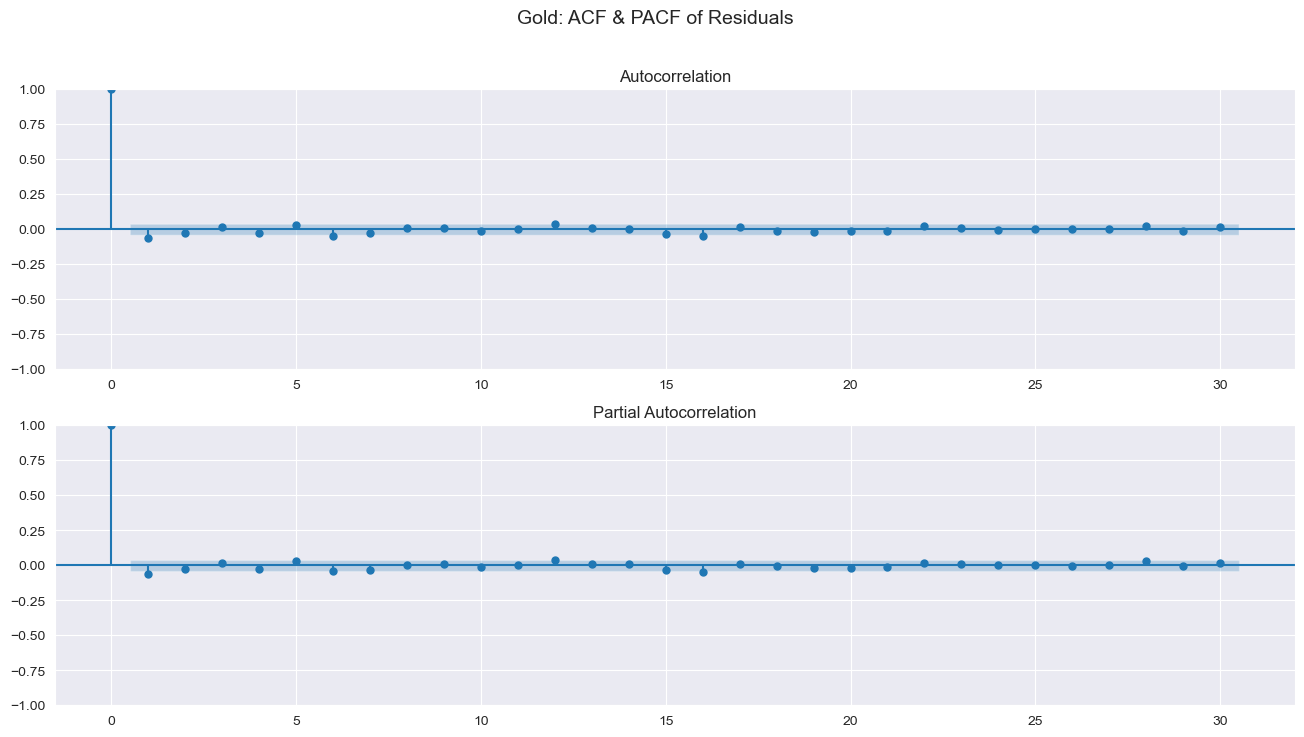

In [202]:
# Taken from Tutorial 5
# Create a figure with two rows for subplots
fig, axes = plt.subplots(nrows=2, figsize=(16, 8))

# Set the 'ax' parameter for subplots
plot_acf(model_gold.resid,lags=30,ax=axes[0]) 
plot_pacf(model_gold.resid,lags=30,ax=axes[1])
plt.suptitle('Gold: ACF & PACF of Residuals', fontsize=14)
plt.show()

In [203]:
# Testing for presence of ARCH effect Gold
arch_name = ['Lagrange Multiplier Test Statistic', 'lm p-value','f-statistic', 'f p-value']
arch_effect_gold = sm.stats.diagnostic.het_arch(model_gold.resid)
print(lzip(arch_name, arch_effect_gold))

[('Lagrange Multiplier Test Statistic', 189.22001279707652), ('lm p-value', 2.841105864561211e-35), ('f-statistic', 20.385803955721922), ('f p-value', 9.850992421794249e-37)]


In [204]:
# GARCH (0,1): Only ARCH term Gold
garch_01_gold = arch_model(data_gol['gold_lr'], vol='ARCH', p=1, q=0).fit()
print(garch_01_gold.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4168498191559.827
Iteration:      2,   Func. Count:     17,   Neg. LLF: 60566110.26059816
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8086.713291802047
            Iterations: 2
            Function evaluations: 23
            Gradient evaluations: 2
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                gold_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                8086.71
Distribution:                  Normal   AIC:                          -16167.4
Method:            Maximum Likelihood   BIC:                          -16150.0
                                        No. Observations:                 2503
Date:                Tue, Dec 16 2025   Df Residuals:                     2502
Time:           

/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.3e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [205]:
# Garch on Gold 
garch_11_gold = arch_model(data_gol['gold_lr'], vol='GARCH', p=1, q=1).fit()
print(garch_11_gold.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8.926154088511335e+20
Iteration:      2,   Func. Count:     19,   Neg. LLF: 632424866926821.5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -8193.327503432369
            Iterations: 3
            Function evaluations: 28
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                gold_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8193.33
Distribution:                  Normal   AIC:                          -16378.7
Method:            Maximum Likelihood   BIC:                          -16355.4
                                        No. Observations:                 2503
Date:                Tue, Dec 16 2025   Df Residuals:                     2502
Time:       

/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.3e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


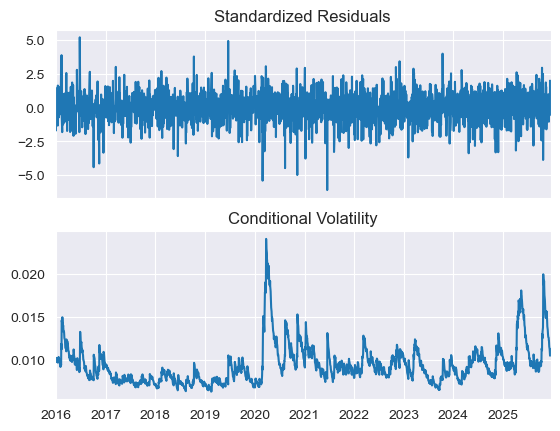

In [206]:
# Checking the standardised residuals Gold
fig_gold = garch_11_gold.plot() 
plt.show()

In [207]:
# Generate 22-step ahead forecast Gold
returns_gold = data_gol['gold_lr'].dropna()

# Fit GARCH model on all data
model_gold = arch_model(returns_gold, vol='GARCH', p=1, q=1)
model_fit_gold = model_gold.fit(disp='off')

# Generate rolling forecasts for last 22 observations
rolling_forecasts_gold = model_fit_gold.forecast(horizon=1, start=len(returns_gold)-22)

# Extract variance forecasts
var_forecast_gold = rolling_forecasts_gold.variance

print(var_forecast_gold)

# CLAUDE was used to help get the 22 trading day forecast - Accessed Date: December 15, 2025

                 h.1
Date                
2025-11-13  0.000228
2025-11-14  0.000243
2025-11-17  0.000229
2025-11-18  0.000215
2025-11-19  0.000203
2025-11-20  0.000192
2025-11-21  0.000181
2025-11-24  0.000171
2025-11-25  0.000167
2025-11-26  0.000159
2025-11-28  0.000157
2025-12-01  0.000149
2025-12-02  0.000149
2025-12-03  0.000141
2025-12-04  0.000133
2025-12-05  0.000126
2025-12-08  0.000121
2025-12-09  0.000115
2025-12-10  0.000109
2025-12-11  0.000125
2025-12-12  0.000119
2025-12-15  0.000112


/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.3e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


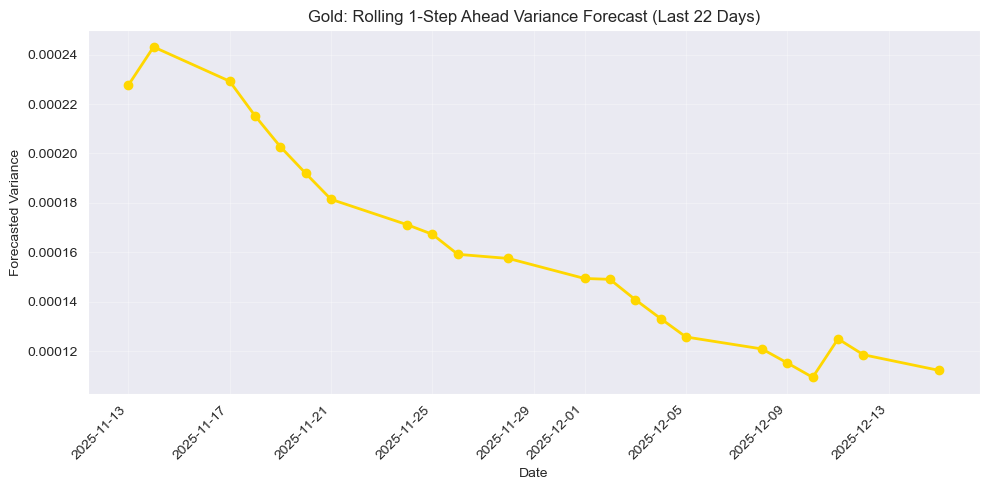

In [208]:
# Plot the rolling forecasts Gold
plt.figure(figsize=(10, 5))

plt.plot(var_forecast_gold.index, var_forecast_gold['h.1'], 
         color='gold', linestyle='-', marker='o', linewidth=2)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Forecasted Variance')
plt.title('Gold: Rolling 1-Step Ahead Variance Forecast (Last 22 Days)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

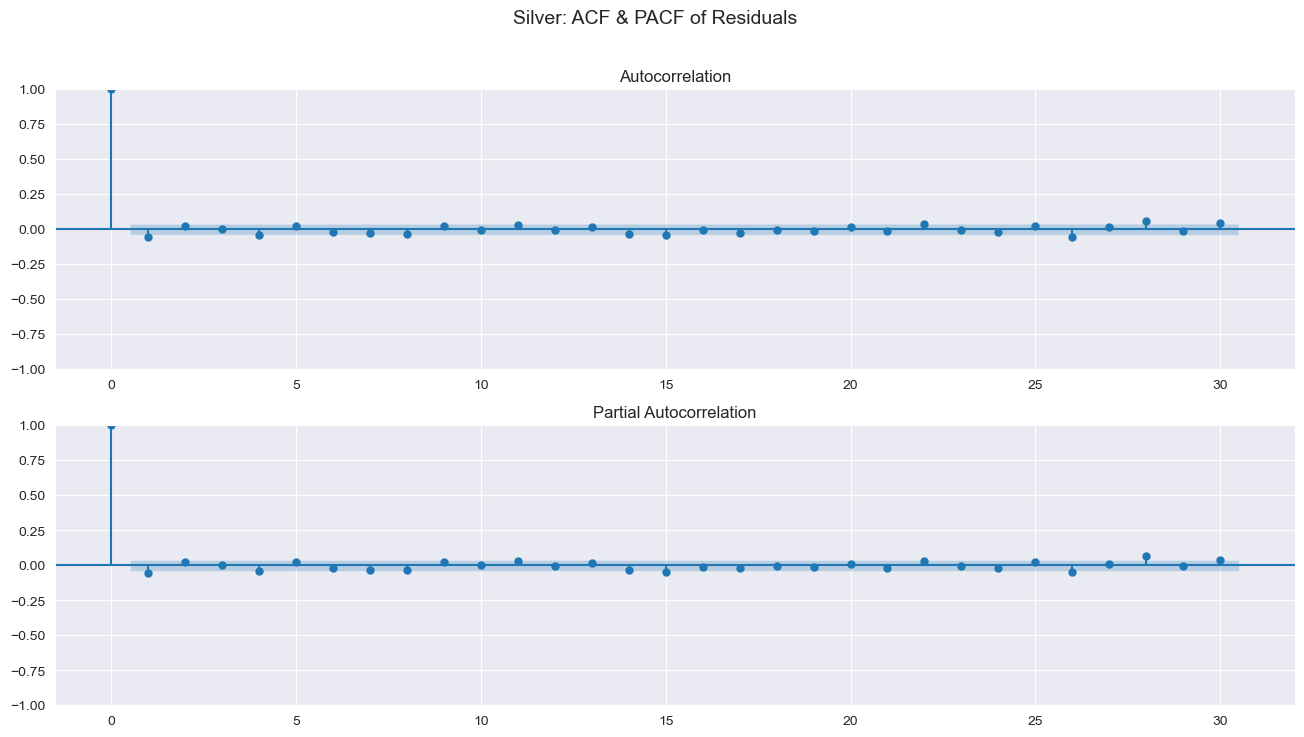

In [209]:
# Taken from Tutorial 5
# Create a figure with two rows for subplots
fig, axes = plt.subplots(nrows=2, figsize=(16, 8))

# Set the 'ax' parameter for subplots
plot_acf(model_silver.resid,lags=30,ax=axes[0]) 
plot_pacf(model_silver.resid,lags=30,ax=axes[1])
plt.suptitle('Silver: ACF & PACF of Residuals', fontsize=14)
plt.show()

In [210]:
# Testing for ARCH effects in Silver
arch_name = ['Lagrange Multiplier Test Statistic', 'lm p-value','f-statistic', 'f p-value']
arch_effect_silver = sm.stats.diagnostic.het_arch(model_silver.resid)
print(lzip(arch_name, arch_effect_silver))

[('Lagrange Multiplier Test Statistic', 168.98701728443783), ('lm p-value', 4.495921833334688e-31), ('f-statistic', 18.04747994178088), ('f p-value', 3.2511325940075834e-32)]


In [211]:
# GARCH (0,1): Only ARCH term Silver
garch_01_silver = arch_model(data_sil['silver_lr'], vol='ARCH', p=1, q=0).fit()
print(garch_01_silver.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 517849908.8347681
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1208.7005070690564
Iteration:      3,   Func. Count:     24,   Neg. LLF: 339793.0582140323
Iteration:      4,   Func. Count:     31,   Neg. LLF: 4414853764387.718
Iteration:      5,   Func. Count:     40,   Neg. LLF: 1166763.0516364852
Iteration:      6,   Func. Count:     51,   Neg. LLF: 6949.57094261418
Iteration:      7,   Func. Count:     61,   Neg. LLF: -6354.215123491963
Iteration:      8,   Func. Count:     68,   Neg. LLF: 926660.8459315535
Iteration:      9,   Func. Count:     78,   Neg. LLF: -6511.037015665898
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6511.037015620216
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 9
                      Constant Mean - ARCH Model Results                      
Dep. Variable:              silver_lr   R-squared:          

/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003402. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [212]:
# GARCH on Silver 
garch_11_silver = arch_model(data_sil['silver_lr'], vol='GARCH', p=1, q=1).fit()
print(garch_11_silver.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 322554889329.607
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2786990291.5793715
Iteration:      3,   Func. Count:     30,   Neg. LLF: 9418307702.901577
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6621.327680580127
            Iterations: 4
            Function evaluations: 40
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              silver_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6621.33
Distribution:                  Normal   AIC:                          -13234.7
Method:            Maximum Likelihood   BIC:                          -13211.4
                                        No. Observations:                 2503
Date:                Tu

/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003402. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


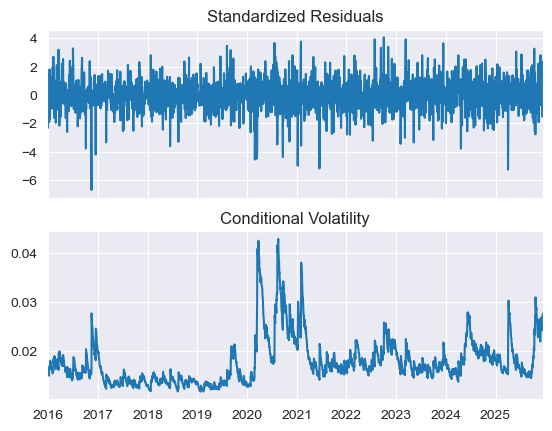

In [213]:
# Checking the standardised residuals Silver
fig_silver = garch_11_silver.plot() 
plt.show()

In [214]:
# Generate 22-step ahead forecast Silver
returns_silver = data_sil['silver_lr'].dropna()

# Fit GARCH model on all data
model_silver = arch_model(returns_silver, vol='GARCH', p=1, q=1)
model_fit_silver = model_silver.fit(disp='off')
# Generate rolling forecasts for last 22 observations
rolling_forecasts_silver = model_fit_silver.forecast(horizon=1, start=len(returns_silver)-22)
# Extract variance forecasts
var_forecast_silver = rolling_forecasts_silver.variance
print(var_forecast_silver)
# CLAUDE was used to help get the 22 trading day forecast - Accessed Date: December 15, 2025


                 h.1
Date                
2025-11-13  0.000621
2025-11-14  0.000700
2025-11-17  0.000658
2025-11-18  0.000620
2025-11-19  0.000585
2025-11-20  0.000557
2025-11-21  0.000528
2025-11-24  0.000501
2025-11-25  0.000480
2025-11-26  0.000526
2025-11-28  0.000703
2025-12-01  0.000719
2025-12-02  0.000678
2025-12-03  0.000637
2025-12-04  0.000618
2025-12-05  0.000618
2025-12-08  0.000588
2025-12-09  0.000635
2025-12-10  0.000598
2025-12-11  0.000725
2025-12-12  0.000765
2025-12-15  0.000750


/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003402. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


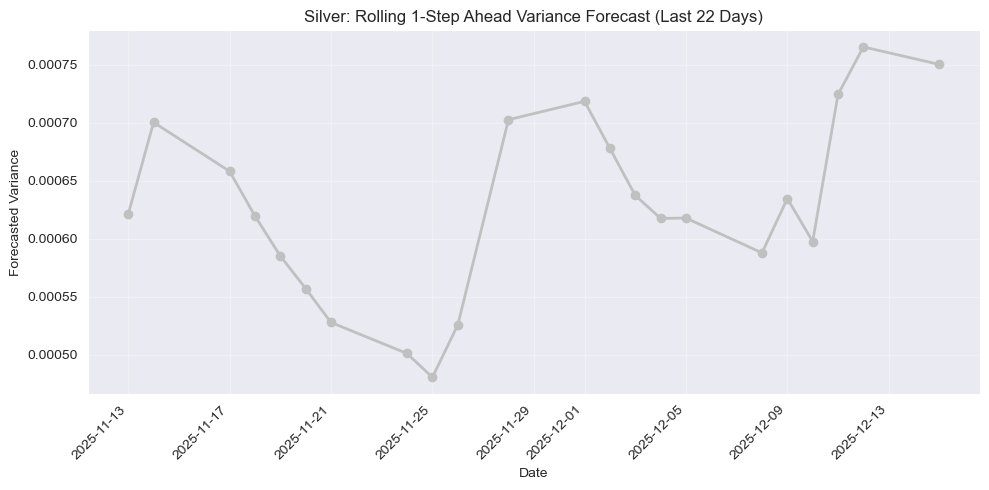

In [215]:
# Plot the rolling forecasts Silver
plt.figure(figsize=(10, 5))

plt.plot(var_forecast_silver.index, var_forecast_silver['h.1'], 
         color='silver', linestyle='-', marker='o', linewidth=2)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Forecasted Variance')
plt.title('Silver: Rolling 1-Step Ahead Variance Forecast (Last 22 Days)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

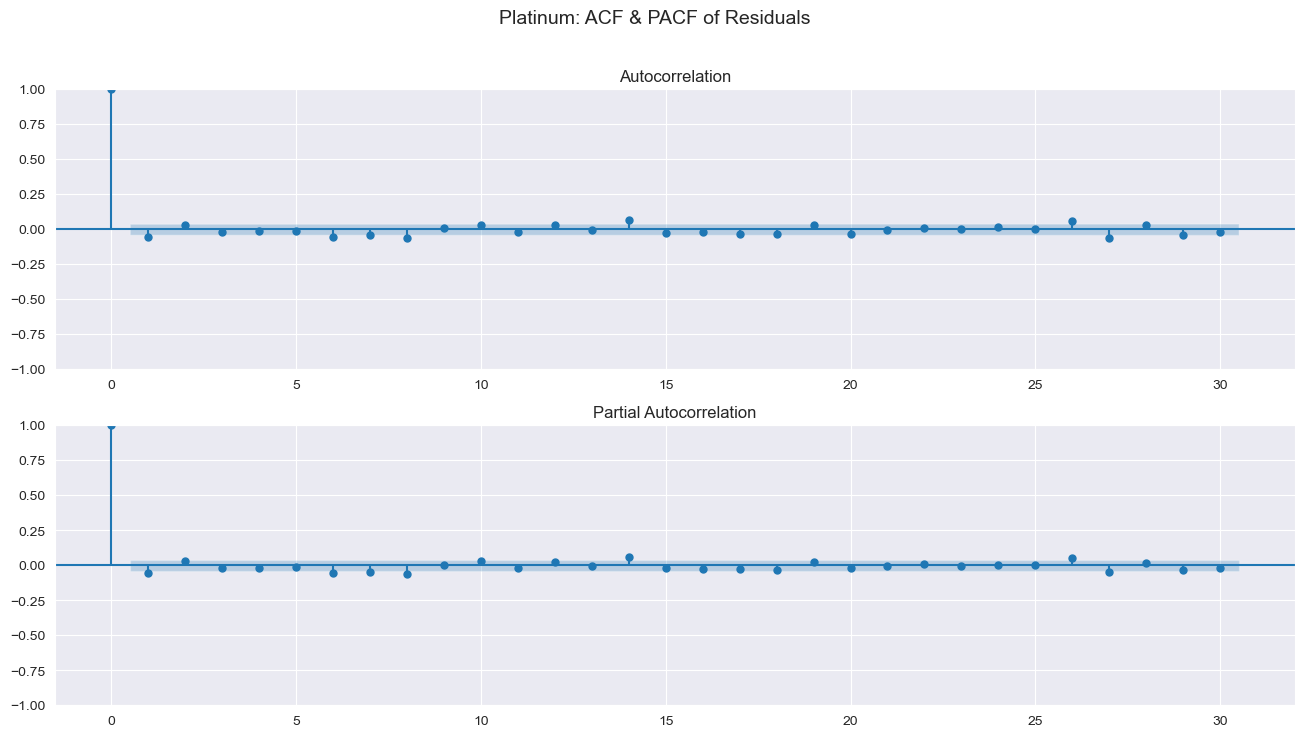

In [216]:
# Taken from Tutorial 5
# Create a figure with two rows for subplots
fig, axes = plt.subplots(nrows=2, figsize=(16, 8))

# Set the 'ax' parameter for subplots
plot_acf(model_platinum.resid,lags=30,ax=axes[0]) 
plot_pacf(model_platinum.resid,lags=30,ax=axes[1])
plt.suptitle('Platinum: ACF & PACF of Residuals', fontsize=14)
plt.show()

In [217]:
# Testing for ARCH effects in Platinum
arch_name = ['Lagrange Multiplier Test Statistic', 'lm p-value','f-statistic', 'f p-value']
arch_effect_platinum = sm.stats.diagnostic.het_arch(model_platinum.resid)
print(lzip(arch_name, arch_effect_platinum))

[('Lagrange Multiplier Test Statistic', 212.89151439764314), ('lm p-value', 3.28072139978502e-40), ('f-statistic', 23.17584781598114), ('f p-value', 4.2467374045210195e-42)]


In [218]:
# GARCH (0,1): Only ARCH term Platinum
garch_01_platinum = arch_model(data_plat['platinum_lr'], vol='ARCH', p=1, q=0).fit()
print(garch_01_platinum.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1336246769191838.2
Iteration:      2,   Func. Count:     16,   Neg. LLF: -4745.019972315487
Iteration:      3,   Func. Count:     23,   Neg. LLF: -6497.683361327603
Iteration:      4,   Func. Count:     28,   Neg. LLF: -6303.505807113213
Iteration:      5,   Func. Count:     34,   Neg. LLF: 2482156.850401542
Iteration:      6,   Func. Count:     40,   Neg. LLF: -6533.212734456152
Iteration:      7,   Func. Count:     45,   Neg. LLF: -6533.266956924301
Iteration:      8,   Func. Count:     49,   Neg. LLF: -6533.266958244412
Iteration:      9,   Func. Count:     52,   Neg. LLF: -6533.266958244405
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6533.266958244412
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 9
                      Constant Mean - ARCH Model Results                      
Dep. Variable:            platinum_lr   R-squared:       

/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000323. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [219]:
# Garch on Platinum 
garch_11_platinum = arch_model(data_plat['platinum_lr'], vol='GARCH', p=1, q=1).fit()
print(garch_11_platinum.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.8730857486291345e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: 503548490987.16534
Iteration:      3,   Func. Count:     32,   Neg. LLF: -6652.165582252659
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6652.165582601389
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            platinum_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6652.17
Distribution:                  Normal   AIC:                          -13296.3
Method:            Maximum Likelihood   BIC:                          -13273.0
                                        No. Observations:                 2501
Date:           

/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000323. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


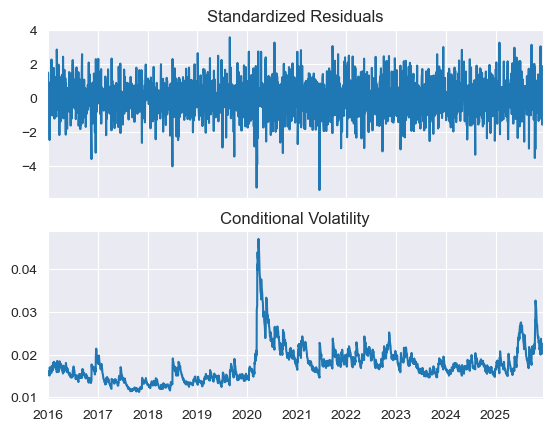

In [220]:
# Checking the standardised residuals Platinum
fig_platinum = garch_11_platinum.plot() 
plt.show()

In [221]:
# Generate 22-step ahead forecast Platinum
returns_platinum = data_plat['platinum_lr'].dropna()
# Fit GARCH model on all data
model_platinum = arch_model(returns_platinum, vol='GARCH', p=1, q=1)
model_fit_platinum = model_platinum.fit(disp='off')
# Generate rolling forecasts for last 22 observations
rolling_forecasts_platinum = model_fit_platinum.forecast(horizon=1, start=len(returns_platinum)-22)
# Extract variance forecasts
var_forecast_platinum = rolling_forecasts_platinum.variance
print(var_forecast_platinum)
# CLAUDE was used to help get the 22 trading day forecast - Accessed Date : December 15, 2025

                 h.1
Date                
2025-11-13  0.000519
2025-11-14  0.000537
2025-11-17  0.000507
2025-11-18  0.000478
2025-11-19  0.000451
2025-11-20  0.000462
2025-11-21  0.000437
2025-11-24  0.000431
2025-11-25  0.000411
2025-11-26  0.000399
2025-11-28  0.000561
2025-12-01  0.000529
2025-12-02  0.000511
2025-12-03  0.000485
2025-12-04  0.000457
2025-12-05  0.000432
2025-12-08  0.000408
2025-12-09  0.000414
2025-12-10  0.000443
2025-12-11  0.000496
2025-12-12  0.000508
2025-12-15  0.000523


/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000323. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


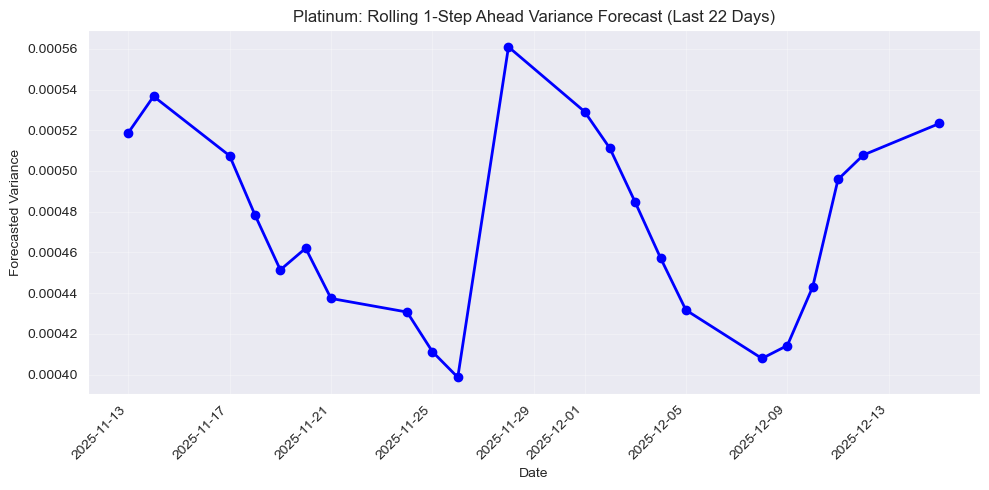

In [222]:
# Plot the rolling forecasts Platinum
plt.figure(figsize=(10, 5))
plt.plot(var_forecast_platinum.index, var_forecast_platinum['h.1'], 
         color='blue', linestyle='-', marker='o', linewidth=2)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Forecasted Variance')
plt.title('Platinum: Rolling 1-Step Ahead Variance Forecast (Last 22 Days)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

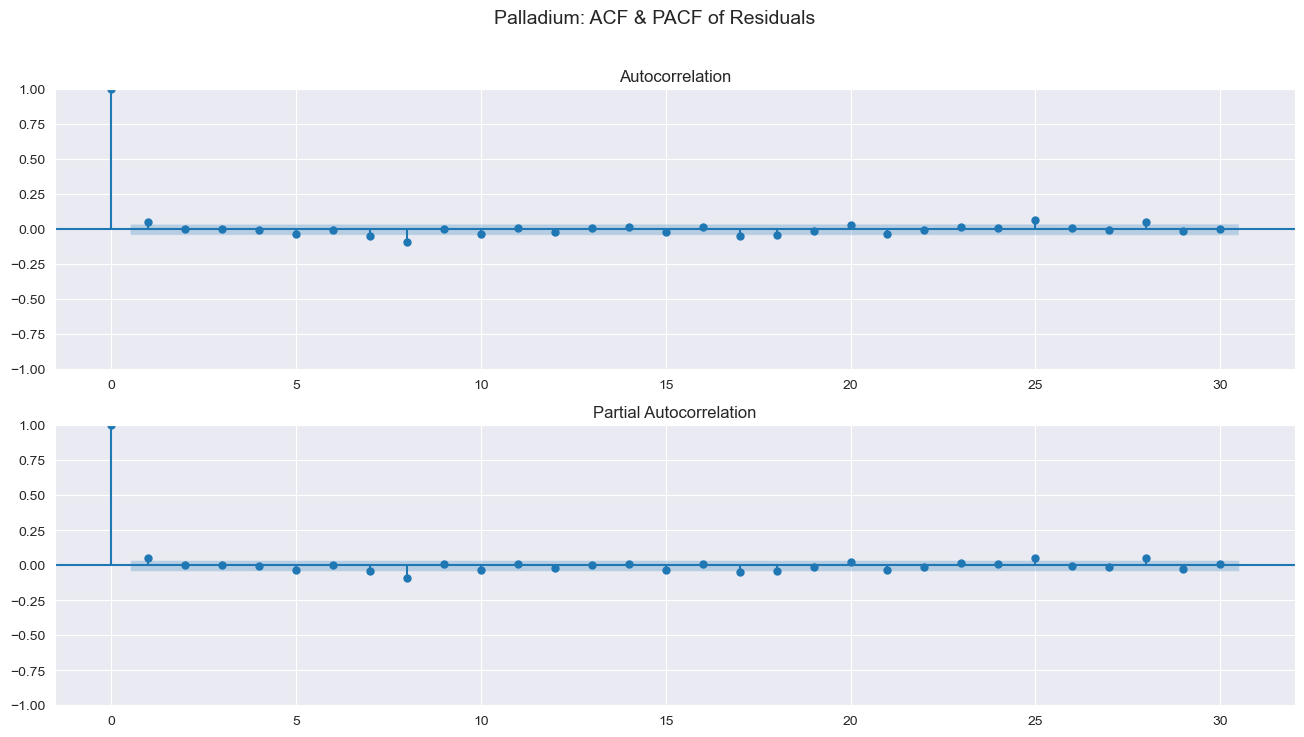

In [223]:
# Taken from Tutorial 5
# Create a figure with two rows for subplots
fig, axes = plt.subplots(nrows=2, figsize=(16, 8))

# Set the 'ax' parameter for subplots
plot_acf(model_palladium.resid,lags=30,ax=axes[0]) 
plot_pacf(model_palladium.resid,lags=30,ax=axes[1])
plt.suptitle('Palladium: ACF & PACF of Residuals', fontsize=14)
plt.show()

In [224]:
# Testing for ARCH effects in Palladium
arch_name = ['Lagrange Multiplier Test Statistic', 'lm p-value','f-statistic', 'f p-value']
arch_effect_palladium = sm.stats.diagnostic.het_arch(model_palladium.resid)
print(lzip(arch_name, arch_effect_palladium))

[('Lagrange Multiplier Test Statistic', 388.297991424888), ('lm p-value', 2.9072703805249192e-77), ('f-statistic', 45.79721780863669), ('f p-value', 3.2863589037290303e-84)]


In [225]:
# GARCH (0,1): Only ARCH term palladium
garch_01_palladium = arch_model(data_pall['palladium_lr'], vol='ARCH', p=1, q=0).fit()
print(garch_01_palladium.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 5936013720.419508
Iteration:      2,   Func. Count:     15,   Neg. LLF: -5850.304880285388
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5850.304880270972
            Iterations: 6
            Function evaluations: 15
            Gradient evaluations: 2
                      Constant Mean - ARCH Model Results                      
Dep. Variable:           palladium_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                5850.30
Distribution:                  Normal   AIC:                          -11694.6
Method:            Maximum Likelihood   BIC:                          -11677.1
                                        No. Observations:                 2501
Date:                Tue, Dec 16 2025   Df Residuals:                     2500
Time:          

/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005975. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [226]:
# GARCH on Palladium 
garch_11_palladium = arch_model(data_pall['palladium_lr'], vol='GARCH', p=1, q=1).fit()
print(garch_11_palladium.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3.5388718022728438e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2857179431144966.5
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5939.722482440082
            Iterations: 3
            Function evaluations: 26
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           palladium_lr   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5939.72
Distribution:                  Normal   AIC:                          -11871.4
Method:            Maximum Likelihood   BIC:                          -11848.1
                                        No. Observations:                 2501
Date:                Tue, Dec 16 2025   Df Residuals:                     2500
Time:     

/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005975. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


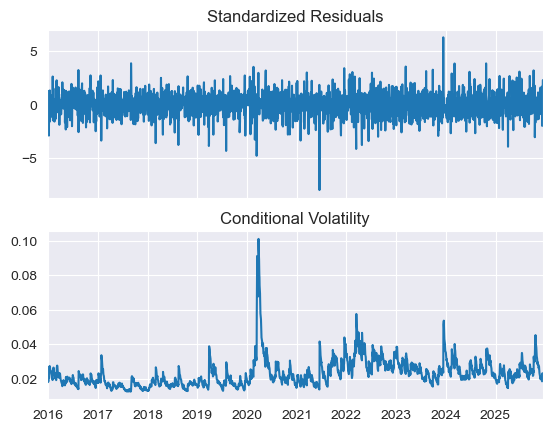

In [227]:
# Checking the standardised residuals Palladium
fig_palladium = garch_11_palladium.plot() 
plt.show()

In [228]:
# Generate 22-step ahead forecast Palladium
returns_palladium = data_pall['palladium_lr'].dropna()
# Fit GARCH model on all data
model_palladium = arch_model(returns_palladium, vol='GARCH', p=1, q=1)
model_fit_palladium = model_palladium.fit(disp='off')
# Generate rolling forecasts for last 22 observations
rolling_forecasts_palladium = model_fit_palladium.forecast(horizon=1, start=len(returns_palladium)-22)
# Extract variance forecasts
var_forecast_palladium = rolling_forecasts_palladium.variance
print(var_forecast_palladium)
# CLAUDE was used to help get the 22 trading day forecast - Accessed Date : December 15, 2025

                 h.1
Date                
2025-11-13  0.000676
2025-11-14  0.000732
2025-11-17  0.000659
2025-11-18  0.000593
2025-11-19  0.000551
2025-11-20  0.000520
2025-11-21  0.000470
2025-11-24  0.000442
2025-11-25  0.000401
2025-11-26  0.000383
2025-11-28  0.000445
2025-12-01  0.000433
2025-12-02  0.000422
2025-12-03  0.000384
2025-12-04  0.000382
2025-12-05  0.000365
2025-12-08  0.000338
2025-12-09  0.000340
2025-12-10  0.000446
2025-12-11  0.000532
2025-12-12  0.000480
2025-12-15  0.000680


/opt/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005975. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


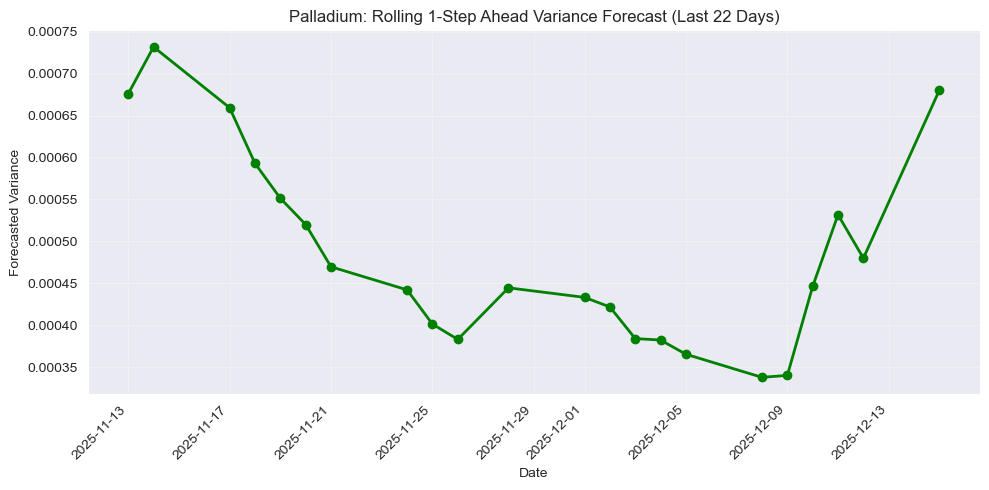

In [229]:
# Plot the rolling forecasts Palladium
plt.figure(figsize=(10, 5))
plt.plot(var_forecast_palladium.index, var_forecast_palladium['h.1'], 
         color='green', linestyle='-', marker='o', linewidth=2)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Forecasted Variance')
plt.title('Palladium: Rolling 1-Step Ahead Variance Forecast (Last 22 Days)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [230]:
# Code taken from CLAUDE Accessed Date: December 15, 2025

# Gold - GARCH(1,1) Rolling Variance Forecast with MSE and QLIKE
train_frac = 0.8
returns_gold = 100*data_gol['gold_lr'].dropna()
T_gold = len(returns_gold)
t0_gold = int(train_frac * T_gold)

# Fit GARCH model on all data
model_gold = arch_model(returns_gold, vol='GARCH', p=1, q=1)
model_fit_gold = model_gold.fit(disp='off')

# Generate rolling forecasts starting from t0_gold
rolling_forecasts_gold = model_fit_gold.forecast(horizon=1, start=t0_gold)
var_forecast_gold = rolling_forecasts_gold.variance['h.1']
realized_r2_gold = returns_gold.iloc[t0_gold:] ** 2

# Calculate MSE and QLIKE
eps = 1e-12
r_gold = np.maximum(realized_r2_gold.values, eps)
f_gold_vals = np.maximum(var_forecast_gold.values, eps)
qlike_vals_gold = np.log(f_gold_vals) + (r_gold / f_gold_vals)

mse_gold = float(np.mean((realized_r2_gold - var_forecast_gold) ** 2))
qlike_gold = float(np.mean(qlike_vals_gold))

print(f"GARCH volatility forecast evaluation — Gold")
print(f"Evaluation window starts at {var_forecast_gold.index.min().date()} (train_frac={train_frac:.0%})")
print(f"MSE (r^2 vs sigma^2 forecast): {mse_gold:.6f}")
print(f"QLIKE (lower is better):   {qlike_gold:.6f}")

GARCH volatility forecast evaluation — Gold
Evaluation window starts at 2023-12-13 (train_frac=80%)
MSE (r^2 vs sigma^2 forecast): 5.481075
QLIKE (lower is better):   1.009980


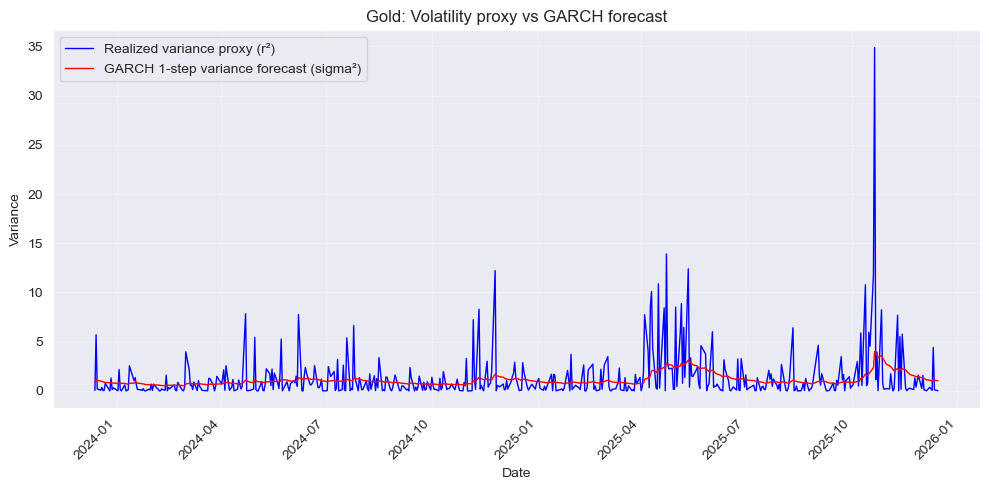

In [231]:
# Plot Gold: Realized variance vs GARCH forecast
plt.figure(figsize=(10, 5))
plt.plot(realized_r2_gold.index, realized_r2_gold.values, 
         label="Realized variance proxy (r²)", color='blue', linestyle='-', linewidth=1)
plt.plot(var_forecast_gold.index, var_forecast_gold.values, 
         label="GARCH 1-step variance forecast (sigma²)", color='red', linestyle='-', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.title('Gold: Volatility proxy vs GARCH forecast')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [232]:
# Code taken from CLAUDE Accessed Date: December 15, 2025

# Silver - GARCH(1,1) Rolling Variance Forecast with MSE and QLIKE
returns_silver = 100*data_sil['silver_lr'].dropna()
T_silver = len(returns_silver)
t0_silver = int(train_frac * T_silver)

# Fit GARCH model on all data
model_silver = arch_model(returns_silver, vol='GARCH', p=1, q=1)
model_fit_silver = model_silver.fit(disp='off')

# Generate rolling forecasts starting from t0_silver
rolling_forecasts_silver = model_fit_silver.forecast(horizon=1, start=t0_silver)
var_forecast_silver = rolling_forecasts_silver.variance['h.1']
realized_r2_silver = returns_silver.iloc[t0_silver:] ** 2

# Calculate MSE and QLIKE
r_silver = np.maximum(realized_r2_silver.values, eps)
f_silver_vals = np.maximum(var_forecast_silver.values, eps)
qlike_vals_silver = np.log(f_silver_vals) + (r_silver / f_silver_vals)

mse_silver = float(np.mean((realized_r2_silver - var_forecast_silver) ** 2))
qlike_silver = float(np.mean(qlike_vals_silver))

print(f"GARCH volatility forecast evaluation — Silver")
print(f"Evaluation window starts at {var_forecast_silver.index.min().date()} (train_frac={train_frac:.0%})")
print(f"MSE (r^2 vs sigma^2 forecast): {mse_silver:.6f}")
print(f"QLIKE (lower is better):   {qlike_silver:.6f}")

GARCH volatility forecast evaluation — Silver
Evaluation window starts at 2023-12-13 (train_frac=80%)
MSE (r^2 vs sigma^2 forecast): 60.308521
QLIKE (lower is better):   2.262134


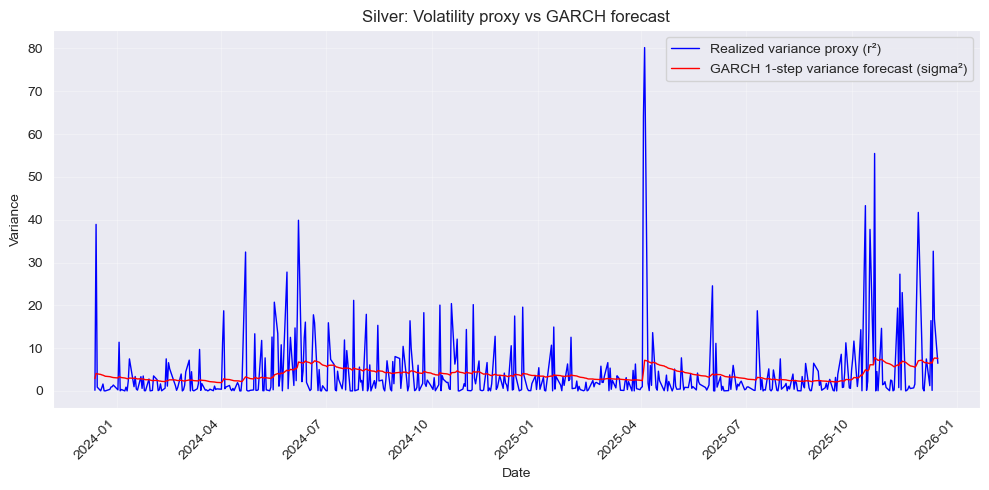

In [233]:
# Plot Silver: Realized variance vs GARCH forecast
plt.figure(figsize=(10, 5))
plt.plot(realized_r2_silver.index, realized_r2_silver.values, label="Realized variance proxy (r²)", color='blue', linestyle='-', linewidth=1)
plt.plot(var_forecast_silver.index, var_forecast_silver.values, label="GARCH 1-step variance forecast (sigma²)", color='red', linestyle='-', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.title('Silver: Volatility proxy vs GARCH forecast')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [234]:
# Code taken from CLAUDE Accessed Date: December 15, 2025

# Platinum - GARCH(1,1) Rolling Variance Forecast with MSE and QLIKE
returns_platinum = 100*data_plat['platinum_lr'].dropna()
T_platinum = len(returns_platinum)
t0_platinum = int(train_frac * T_platinum)

# Fit GARCH model on all data
model_platinum = arch_model(returns_platinum, vol='GARCH', p=1, q=1)
model_fit_platinum = model_platinum.fit(disp='off')

# Generate rolling forecasts starting from t0_platinum
rolling_forecasts_platinum = model_fit_platinum.forecast(horizon=1, start=t0_platinum)
var_forecast_platinum = rolling_forecasts_platinum.variance['h.1']
realized_r2_platinum = returns_platinum.iloc[t0_platinum:] ** 2

# Calculate MSE and QLIKE
r_platinum = np.maximum(realized_r2_platinum.values, eps)
f_platinum_vals = np.maximum(var_forecast_platinum.values, eps)
qlike_vals_platinum = np.log(f_platinum_vals) + (r_platinum / f_platinum_vals)

mse_platinum = float(np.mean((realized_r2_platinum - var_forecast_platinum) ** 2))
qlike_platinum = float(np.mean(qlike_vals_platinum))

print(f"GARCH volatility forecast evaluation — Platinum")
print(f"Evaluation window starts at {var_forecast_platinum.index.min().date()} (train_frac={train_frac:.0%})")
print(f"MSE (r^2 vs σ^2 forecast): {mse_platinum:.6f}")
print(f"QLIKE (lower is better):   {qlike_platinum:.6f}")

GARCH volatility forecast evaluation — Platinum
Evaluation window starts at 2023-12-13 (train_frac=80%)
MSE (r^2 vs σ^2 forecast): 40.769055
QLIKE (lower is better):   2.212899


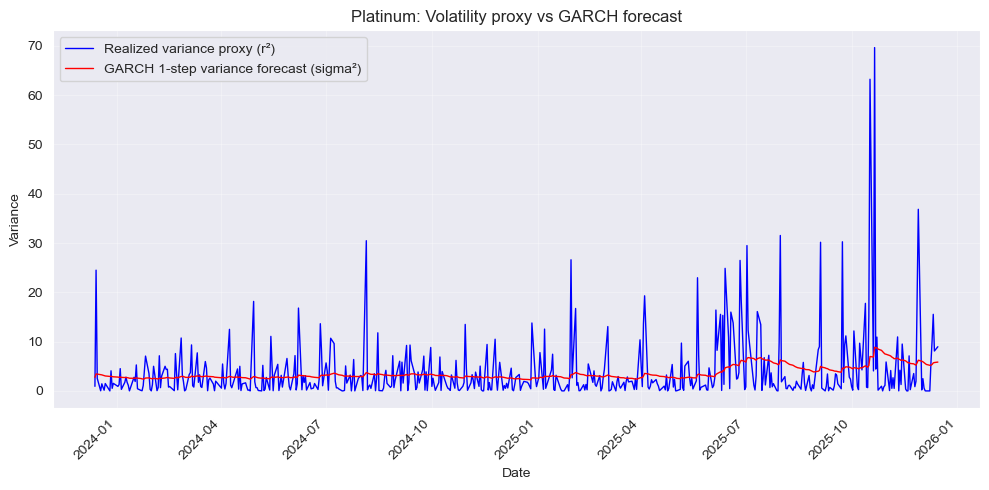

In [235]:
# Plot Platinum: Realized variance vs GARCH forecast
plt.figure(figsize=(10, 5))
plt.plot(realized_r2_platinum.index, realized_r2_platinum.values, label="Realized variance proxy (r²)", color='blue', linestyle='-', linewidth=1)
plt.plot(var_forecast_platinum.index, var_forecast_platinum.values, label="GARCH 1-step variance forecast (sigma²)", color='red', linestyle='-', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.title('Platinum: Volatility proxy vs GARCH forecast')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [236]:
# Code taken from CLAUDE Accessed Date: December 15, 2025

# Palladium - GARCH(1,1) Rolling Variance Forecast with MSE and QLIKE
returns_palladium = 100*data_pall['palladium_lr'].dropna()
T_palladium = len(returns_palladium)
t0_palladium = int(train_frac * T_palladium)

# Fit GARCH model on all data
model_palladium = arch_model(returns_palladium, vol='GARCH', p=1, q=1)
model_fit_palladium = model_palladium.fit(disp='off')

# Generate rolling forecasts starting from t0_palladium
rolling_forecasts_palladium = model_fit_palladium.forecast(horizon=1, start=t0_palladium)
var_forecast_palladium = rolling_forecasts_palladium.variance['h.1']
realized_r2_palladium = returns_palladium.iloc[t0_palladium:] ** 2

# Calculate MSE and QLIKE
r_palladium = np.maximum(realized_r2_palladium.values, eps)
f_palladium_vals = np.maximum(var_forecast_palladium.values, eps)
qlike_vals_palladium = np.log(f_palladium_vals) + (r_palladium / f_palladium_vals)

mse_palladium = float(np.mean((realized_r2_palladium - var_forecast_palladium) ** 2))
qlike_palladium = float(np.mean(qlike_vals_palladium))

print(f"GARCH volatility forecast evaluation — Palladium")
print(f"Evaluation window starts at {var_forecast_palladium.index.min().date()} (train_frac={train_frac:.0%})")
print(f"MSE (r^2 vs σ^2 forecast): {mse_palladium:.6f}")
print(f"QLIKE (lower is better):   {qlike_palladium:.6f}")



GARCH volatility forecast evaluation — Palladium
Evaluation window starts at 2023-12-13 (train_frac=80%)
MSE (r^2 vs σ^2 forecast): 186.598954
QLIKE (lower is better):   2.740060


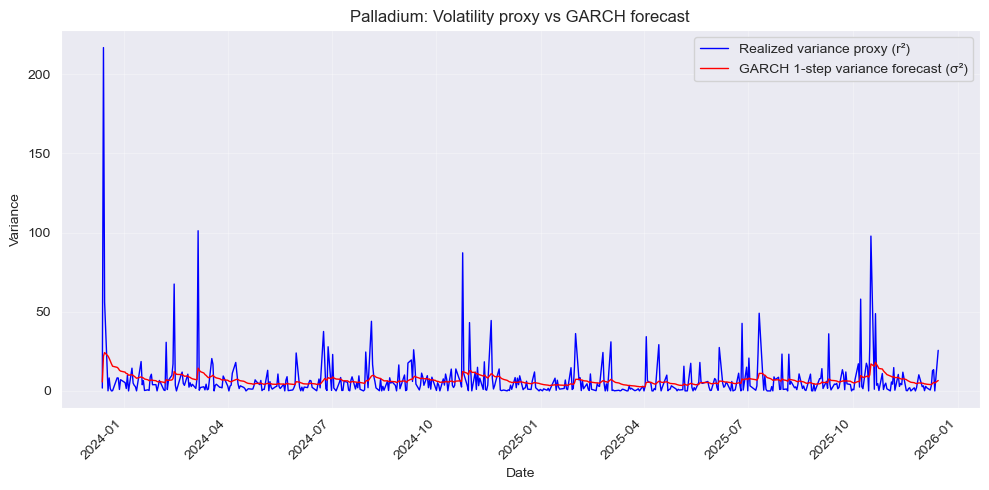

In [237]:
# Plot Palladium: Realized variance vs GARCH forecast
plt.figure(figsize=(10, 5))
plt.plot(realized_r2_palladium.index, realized_r2_palladium.values, label="Realized variance proxy (r²)", color='blue', linestyle='-', linewidth=1)
plt.plot(var_forecast_palladium.index, var_forecast_palladium.values, label="GARCH 1-step variance forecast (σ²)", color='red', linestyle='-', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.title('Palladium: Volatility proxy vs GARCH forecast')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [238]:
vol_eval = pd.DataFrame([
    {"Metal": "Gold", "MSE (r² vs σ²)": mse_gold, "QLIKE": qlike_gold, "N_eval": len(var_forecast_gold)},
    {"Metal": "Silver", "MSE (r² vs σ²)": mse_silver, "QLIKE": qlike_silver, "N_eval": len(var_forecast_silver)},
    {"Metal": "Platinum", "MSE (r² vs σ²)": mse_platinum, "QLIKE": qlike_platinum, "N_eval": len(var_forecast_platinum)},
    {"Metal": "Palladium", "MSE (r² vs σ²)": mse_palladium, "QLIKE": qlike_palladium, "N_eval": len(var_forecast_palladium)}
]).sort_values("QLIKE").reset_index(drop=True)

print("\nVolatility forecast evaluation summary (lower QLIKE is better)")
display(vol_eval)


Volatility forecast evaluation summary (lower QLIKE is better)


,Metal,MSE (r² vs σ²),QLIKE,N_eval
0,Gold,5.481075,1.009980,501
1,Platinum,40.769055,2.212899,501
2,Silver,60.308521,2.262134,501
3,Palladium,186.598954,2.740060,501


In [239]:
# Edited from Tutorial 5

# Gold - Fit ARMA models and compare AIC/BIC
gold_returns = data_gol['gold_lr'].dropna()
gold_returns = gold_returns.asfreq('B')

print(f"Gold returns length: {len(gold_returns)}")
print(f"Gold returns sample:\n{gold_returns.head()}")

# Initialize a list to store model comparison results
arma_model_results_gold = []

# Define a range of AR and MA orders
p_range = range(0, 3)  # AR terms (0 to 2)
q_range = range(0, 3)  # MA terms (0 to 2)

# Iterate over all combinations of AR (p) and MA (q) orders
for p in p_range:
    for q in q_range:
        try:
            # Fit ARMA model
            arma_model_gold = ARIMA(gold_returns, order=(p, 0, q))
            arma_fitted_gold = arma_model_gold.fit()
            # Store results
            arma_model_results_gold.append({
                'AR(p)': p,
                'MA(q)': q,
                'AIC': arma_fitted_gold.aic,
                'BIC': arma_fitted_gold.bic
            })
            print(f"ARMA({p},{q}) fitted successfully")
        except Exception as e:
            # Handle exceptions for models that fail
            print(f"ARMA({p},{q}) failed: {e}")
            arma_model_results_gold.append({
                'AR(p)': p,
                'MA(q)': q,
                'AIC': None,
                'BIC': None
            })

# Convert results to DataFrame and sort by AIC
arma_results_df_gold = pd.DataFrame(arma_model_results_gold)
arma_results_df_gold = arma_results_df_gold.dropna().sort_values(by='AIC')

# Display comparison
print("\nARMA Model Comparison (AIC, BIC) - Gold:")
print(arma_results_df_gold)

Gold returns length: 2605
Gold returns sample:
Date
2015-12-22   -0.006584
2015-12-23   -0.005037
2015-12-24    0.007267
2015-12-25         NaN
2015-12-28   -0.006239
Freq: B, Name: gold_lr, dtype: float64
ARMA(0,0) fitted successfully
ARMA(0,1) fitted successfully
ARMA(0,2) fitted successfully
ARMA(1,0) fitted successfully
ARMA(1,1) fitted successfully
ARMA(1,2) fitted successfully
ARMA(2,0) fitted successfully
ARMA(2,1) fitted successfully


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2,2) fitted successfully

ARMA Model Comparison (AIC, BIC) - Gold:
   AR(p)  MA(q)           AIC           BIC
1      0      1 -16128.071682 -16110.476118
3      1      0 -16128.046438 -16110.450874
0      0      0 -16127.941604 -16116.211228
6      2      0 -16126.169215 -16102.708463
2      0      2 -16126.128920 -16102.668168
4      1      1 -16126.105523 -16102.644772
5      1      2 -16124.901594 -16095.575654
7      2      1 -16121.942402 -16092.616463
8      2      2 -16119.027178 -16083.836050


In [240]:
# Gold - Fit best model
best_p_gold = int(arma_results_df_gold.iloc[0]['AR(p)'])
best_q_gold = int(arma_results_df_gold.iloc[0]['MA(q)'])

arma_best_gold = ARIMA(gold_returns, order=(best_p_gold, 0, best_q_gold))
arma_best_fitted_gold = arma_best_gold.fit()

print(f"\nBest ARMA Model for Gold: ARMA({best_p_gold},{best_q_gold})")
print(arma_best_fitted_gold.summary())


Best ARMA Model for Gold: ARMA(0,1)
                               SARIMAX Results                                
Dep. Variable:                gold_lr   No. Observations:                 2605
Model:                 ARIMA(0, 0, 1)   Log Likelihood                8067.036
Date:                Tue, 16 Dec 2025   AIC                         -16128.072
Time:                        16:35:34   BIC                         -16110.476
Sample:                    12-22-2015   HQIC                        -16121.697
                         - 12-15-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.877      0.004       0.000       0.001
ma.L1         -0.0285      0.015     -1.862      0.063      -0.059       0.001
sigma2      9.2

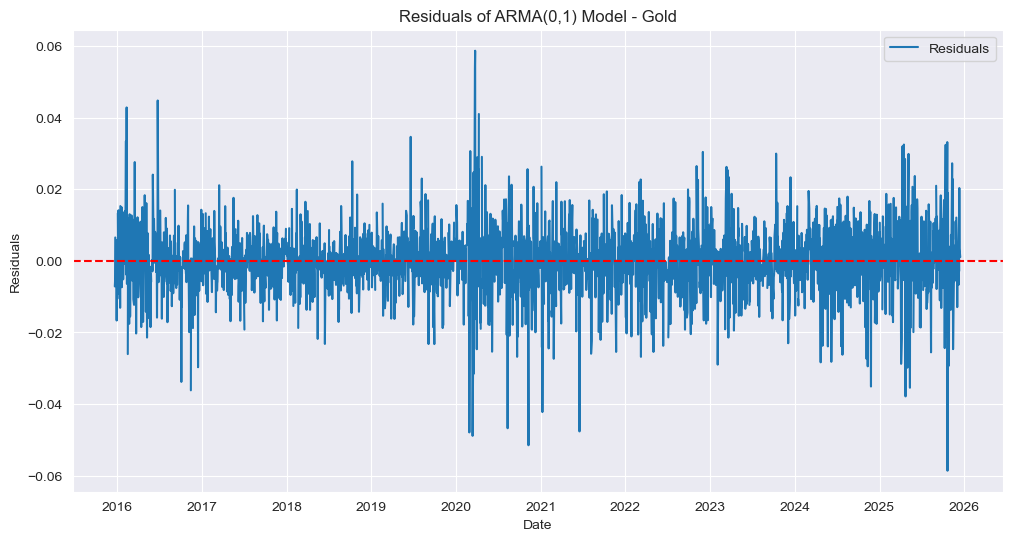

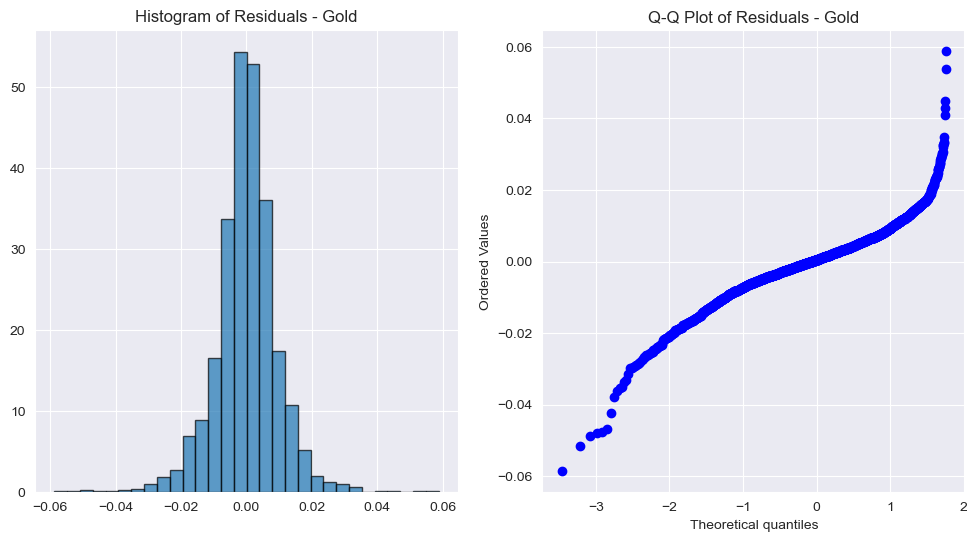

In [241]:
# Gold - Extract residuals
residuals_gold = arma_best_fitted_gold.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_gold, label="Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residuals of ARMA({best_p_gold},{best_q_gold}) Model - Gold")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# Plot histogram and Q-Q plot
from scipy.stats import probplot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Histogram
axes[0].hist(residuals_gold, bins=30, density=True, alpha=0.7, edgecolor='black')
axes[0].set_title("Histogram of Residuals - Gold")
# Q-Q plot
probplot(residuals_gold, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot of Residuals - Gold")
plt.show()

In [242]:
# Silver - Fit ARMA models and compare AIC/BIC
silver_returns = data_sil['silver_lr'].dropna()
silver_returns = silver_returns.asfreq('B')
print(f"Silver returns length: {len(silver_returns)}")
print(f"Silver returns sample:\n{silver_returns.head()}")
# Initialize a list to store model comparison results
arma_model_results_silver = []
# Define a range of AR and MA orders
p_range = range(0, 3)  # AR terms (0 to 2
q_range = range(0, 3)  # MA terms (0 to 2)
# Iterate over all combinations of AR (p) and MA (q) orders
for p in p_range:
    for q in q_range:
        try:
            # Fit ARMA model
            arma_model_silver = ARIMA(silver_returns, order=(p, 0, q))
            arma_fitted_silver = arma_model_silver.fit()
            # Store results
            arma_model_results_silver.append({
                'AR(p)': p,
                'MA(q)': q,
                'AIC': arma_fitted_silver.aic,
                'BIC': arma_fitted_silver.bic
            })
            print(f"ARMA({p},{q}) fitted successfully")
        except Exception as e:
            # Handle exceptions for models that fail
            print(f"ARMA({p},{q}) failed: {e}")
            arma_model_results_silver.append({
                'AR(p)': p,
                'MA(q)': q,
                'AIC': None,
                'BIC': None
            }) 
# Convert results to DataFrame and sort by AIC
arma_results_df_silver = pd.DataFrame(arma_model_results_silver)
arma_results_df_silver = arma_results_df_silver.dropna().sort_values(by='AIC')
# Display comparison
print("\nARMA Model Comparison (AIC, BIC) - Silver:")
print(arma_results_df_silver)

Silver returns length: 2605
Silver returns sample:
Date
2015-12-22    0.000070
2015-12-23   -0.001750
2015-12-24    0.006423
2015-12-25         NaN
2015-12-28   -0.035129
Freq: B, Name: silver_lr, dtype: float64
ARMA(0,0) fitted successfully
ARMA(0,1) fitted successfully
ARMA(0,2) fitted successfully
ARMA(1,0) fitted successfully
ARMA(1,1) fitted successfully
ARMA(1,2) fitted successfully
ARMA(2,0) fitted successfully
ARMA(2,1) fitted successfully
ARMA(2,2) fitted successfully

ARMA Model Comparison (AIC, BIC) - Silver:
   AR(p)  MA(q)           AIC           BIC
2      0      2 -12888.121728 -12864.660976
6      2      0 -12887.385950 -12863.925198
5      1      2 -12886.120499 -12856.794559
7      2      1 -12885.372757 -12856.046817
8      2      2 -12885.345133 -12850.154005
0      0      0 -12881.959098 -12870.228722
4      1      1 -12881.662590 -12858.201838
3      1      0 -12881.358997 -12863.763433
1      0      1 -12881.213118 -12863.617554


In [ ]:
# Silver - Fit best model
best_p_silver = int(arma_results_df_silver.iloc[0]['AR(p)'])
best_q_silver = int(arma_results_df_silver.iloc[0]['MA(q)'])

arma_best_silver = ARIMA(silver_returns, order=(best_p_silver, 0, best_q_silver))
arma_best_fitted_silver = arma_best_silver.fit()

print(f"\nBest ARMA Model for Silver: ARMA({best_p_silver},{best_q_silver})")
print(arma_best_fitted_silver.summary())

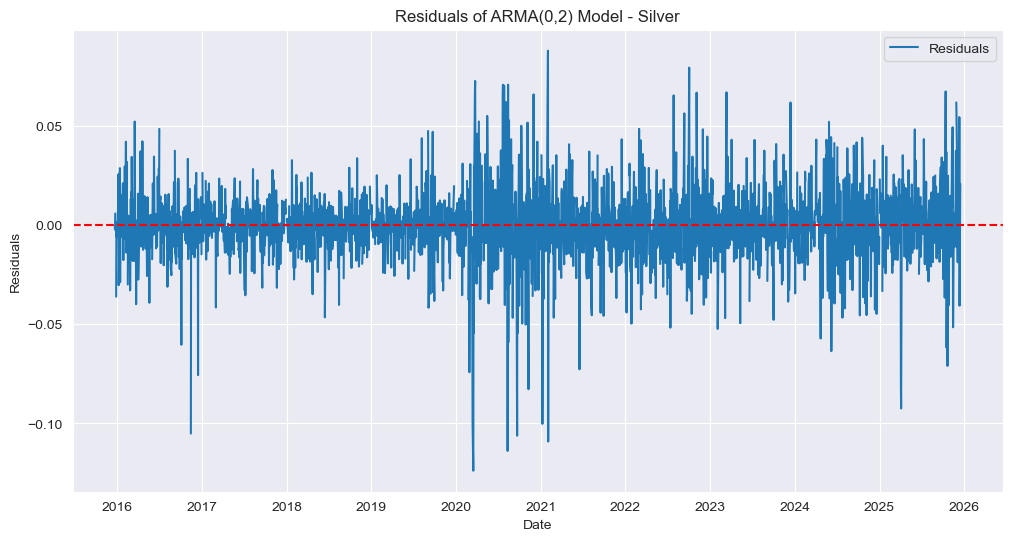

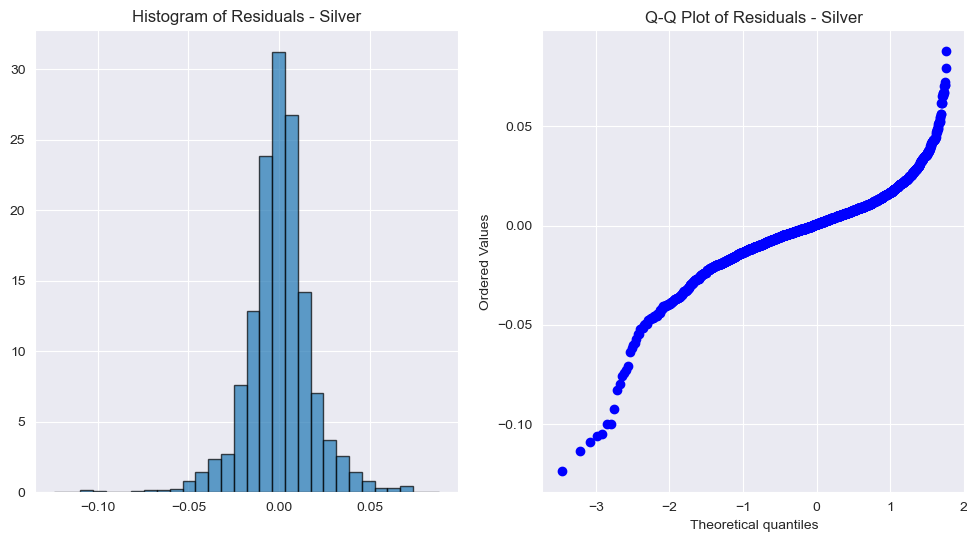

In [ ]:
# Silver - Extract residuals
residuals_silver = arma_best_fitted_silver.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_silver, label="Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residuals of ARMA({best_p_silver},{best_q_silver}) Model - Silver")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# Plot histogram and Q-Q plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Histogram
axes[0].hist(residuals_silver, bins=30, density=True, alpha=0.7, edgecolor='black')
axes[0].set_title("Histogram of Residuals - Silver")
# Q-Q plot
probplot(residuals_silver, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot of Residuals - Silver")
plt.show()


In [ ]:
# Platinum - Fit ARMA models and compare AIC/BIC
platinum_returns = data_plat['platinum_lr'].dropna()
platinum_returns = platinum_returns.asfreq('B')
print(f"Platinum returns length: {len(platinum_returns)}")
print(f"Platinum returns sample:\n{platinum_returns.head()}")
# Initialize a list to store model comparison results
arma_model_results_platinum = []
# Define a range of AR and MA orders
p_range = range(0, 3)  # AR terms (0 to 2)
q_range = range(0, 3)  # MA terms (0 to 2)
# Iterate over all combinations of AR (p) and MA (q) orders
for p in p_range:
    for q in q_range:
        try:
            # Fit ARMA model
            arma_model_platinum = ARIMA(platinum_returns, order=(p, 0, q))
            arma_fitted_platinum = arma_model_platinum.fit()
            # Store results
            arma_model_results_platinum.append({
                'AR(p)': p,
                'MA(q)': q,
                'AIC': arma_fitted_platinum.aic,
                'BIC': arma_fitted_platinum.bic
            })
            print(f"ARMA({p},{q}) fitted successfully")
        except Exception as e:
            # Handle exceptions for models that fail
            print(f"ARMA({p},{q}) failed: {e}")
            arma_model_results_platinum.append({
                'AR(p)': p,
                'MA(q)': q,
                'AIC': None,
                'BIC': None
            })
# Convert results to DataFrame and sort by AIC
arma_results_df_platinum = pd.DataFrame(arma_model_results_platinum)
arma_results_df_platinum = arma_results_df_platinum.dropna().sort_values(by='AIC')
# Display comparison
print("\nARMA Model Comparison (AIC, BIC) - Platinum:")
print(arma_results_df_platinum)

Platinum returns length: 2605
Platinum returns sample:
Date
2015-12-22   -0.009465
2015-12-23   -0.005630
2015-12-24    0.017702
2015-12-25         NaN
2015-12-28   -0.003856
Freq: B, Name: platinum_lr, dtype: float64
ARMA(0,0) fitted successfully
ARMA(0,1) fitted successfully
ARMA(0,2) fitted successfully
ARMA(1,0) fitted successfully
ARMA(1,1) fitted successfully
ARMA(1,2) fitted successfully
ARMA(2,0) fitted successfully
ARMA(2,1) fitted successfully
ARMA(2,2) fitted successfully

ARMA Model Comparison (AIC, BIC) - Platinum:
   AR(p)  MA(q)           AIC           BIC
2      0      2 -13001.809438 -12978.348686
6      2      0 -13001.439755 -12977.979003
0      0      0 -13001.200426 -12989.470050
3      1      0 -12999.817375 -12982.221811
5      1      2 -12999.782299 -12970.456359
1      0      1 -12999.763670 -12982.168106
4      1      1 -12998.428690 -12974.967938
8      2      2 -12997.858703 -12962.667575
7      2      1 -12997.832271 -12968.506331


In [ ]:
# Platinum - Fit best model
best_p_platinum = int(arma_results_df_platinum.iloc[0]['AR(p)'])
best_q_platinum = int(arma_results_df_platinum.iloc[0]['MA(q)'])

arma_best_platinum = ARIMA(platinum_returns, order=(best_p_platinum, 0, best_q_platinum))
arma_best_fitted_platinum = arma_best_platinum.fit()

print(f"\nBest ARMA Model for Platinum: ARMA({best_p_platinum},{best_q_platinum})")
print(arma_best_fitted_platinum.summary())


Best ARMA Model for Platinum: ARMA(0,2)
                               SARIMAX Results                                
Dep. Variable:            platinum_lr   No. Observations:                 2605
Model:                 ARIMA(0, 0, 2)   Log Likelihood                6504.905
Date:                Tue, 16 Dec 2025   AIC                         -13001.809
Time:                        16:34:57   BIC                         -12978.349
Sample:                    12-22-2015   HQIC                        -12993.310
                         - 12-15-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.814      0.415      -0.000       0.001
ma.L1         -0.0123      0.016     -0.765      0.444      -0.044       0.019
ma.L2      

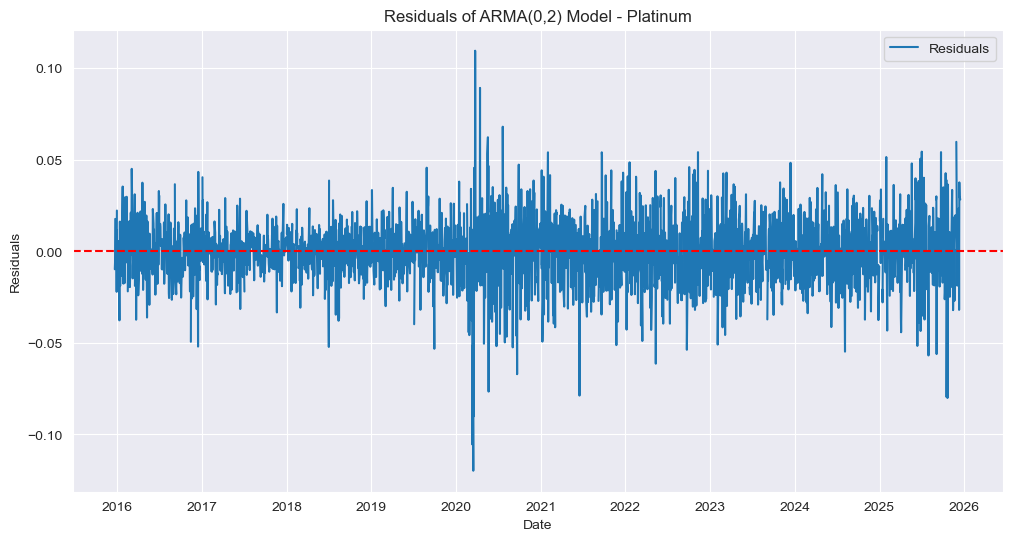

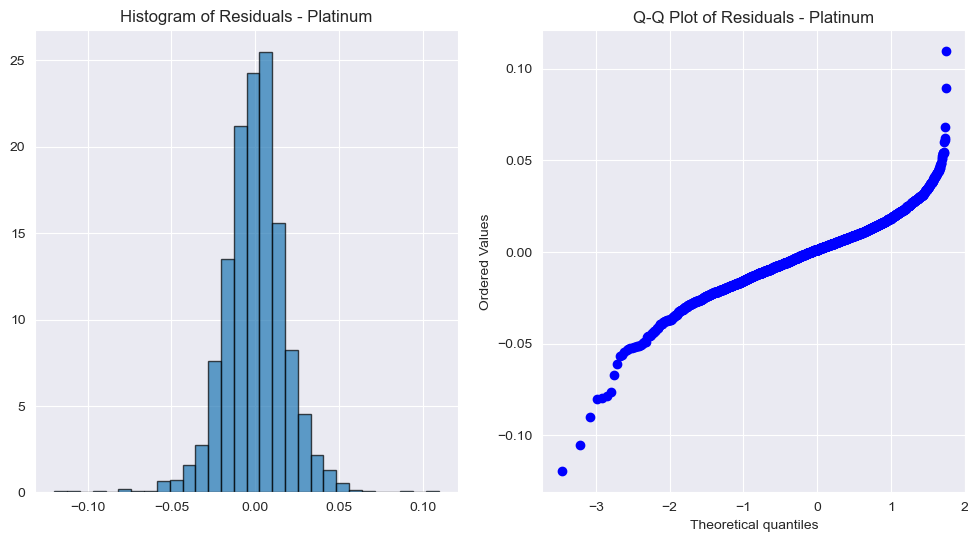

In [ ]:
# Platinum - Extract residuals
residuals_platinum = arma_best_fitted_platinum.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_platinum, label="Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residuals of ARMA({best_p_platinum},{best_q_platinum}) Model - Platinum")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# Plot histogram and Q-Q plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Histogram
axes[0].hist(residuals_platinum, bins=30, density=True, alpha=0.7, edgecolor='black')
axes[0].set_title("Histogram of Residuals - Platinum")
# Q-Q plot
probplot(residuals_platinum, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot of Residuals - Platinum")
plt.show()


In [ ]:
# Palladium - Fit ARMA models and compare AIC/BIC
palladium_returns = data_pall['palladium_lr'].dropna()
palladium_returns = palladium_returns.asfreq('B')
print(f"Palladium returns length: {len(palladium_returns)}")
print(f"Palladium returns sample:\n{palladium_returns.head()}")
# Initialize a list to store model comparison results
arma_model_results_palladium = []
# Define a range of AR and MA orders
p_range = range(0, 3)  # AR terms (0 to 2)
q_range = range(0, 3)  # MA terms (0 to 2)
# Iterate over all combinations of AR (p) and MA (q) orders
for p in p_range:
    for q in q_range:
        try:
            # Fit ARMA model
            arma_model_palladium = ARIMA(palladium_returns, order=(p, 0, q))
            arma_fitted_palladium = arma_model_palladium.fit()
            # Store results
            arma_model_results_palladium.append({
                'AR(p)': p,
                'MA(q)': q,
                'AIC': arma_fitted_palladium.aic,
                'BIC': arma_fitted_palladium.bic
            })
            print(f"ARMA({p},{q}) fitted successfully")
        except Exception as e:
            # Handle exceptions for models that fail
            print(f"ARMA({p},{q}) failed: {e}")
            arma_model_results_palladium.append({
                'AR(p)': p,
                'MA(q)': q,
                'AIC': None,
                'BIC': None
            })
# Convert results to DataFrame and sort by AIC
arma_results_df_palladium = pd.DataFrame(arma_model_results_palladium)
arma_results_df_palladium = arma_results_df_palladium.dropna().sort_values(by='AIC')
# Display comparison
print("\nARMA Model Comparison (AIC, BIC) - Palladium:")
print(arma_results_df_palladium)

Palladium returns length: 2605
Palladium returns sample:
Date
2015-12-22    0.003882
2015-12-23   -0.002617
2015-12-24    0.010872
2015-12-25         NaN
2015-12-28   -0.013495
Freq: B, Name: palladium_lr, dtype: float64
ARMA(0,0) fitted successfully
ARMA(0,1) fitted successfully
ARMA(0,2) fitted successfully
ARMA(1,0) fitted successfully
ARMA(1,1) fitted successfully


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(1,2) fitted successfully
ARMA(2,0) fitted successfully
ARMA(2,1) fitted successfully


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2,2) fitted successfully

ARMA Model Comparison (AIC, BIC) - Palladium:
   AR(p)  MA(q)           AIC           BIC
1      0      1 -11471.360865 -11453.765302
3      1      0 -11471.285229 -11453.689666
6      2      0 -11469.434248 -11445.973496
2      0      2 -11469.426830 -11445.966078
4      1      1 -11469.150761 -11445.690010
7      2      1 -11467.601777 -11438.275837
5      1      2 -11467.427797 -11438.101857
8      2      2 -11465.422446 -11430.231319
0      0      0 -11462.583777 -11450.853401


In [ ]:
# Palladium - Fit best model
best_p_palladium = int(arma_results_df_palladium.iloc[0]['AR(p)'])
best_q_palladium = int(arma_results_df_palladium.iloc[0]['MA(q)'])

arma_best_palladium = ARIMA(palladium_returns, order=(best_p_palladium, 0, best_q_palladium))
arma_best_fitted_palladium = arma_best_palladium.fit()

print(f"\nBest ARMA Model for Palladium: ARMA({best_p_palladium},{best_q_palladium})")
print(arma_best_fitted_palladium.summary())


Best ARMA Model for Palladium: ARMA(0,1)
                               SARIMAX Results                                
Dep. Variable:           palladium_lr   No. Observations:                 2605
Model:                 ARIMA(0, 0, 1)   Log Likelihood                5738.680
Date:                Tue, 16 Dec 2025   AIC                         -11471.361
Time:                        16:35:00   BIC                         -11453.765
Sample:                    12-22-2015   HQIC                        -11464.986
                         - 12-15-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.886      0.376      -0.001       0.001
ma.L1          0.0616      0.013      4.614      0.000       0.035       0.088
sigma2    

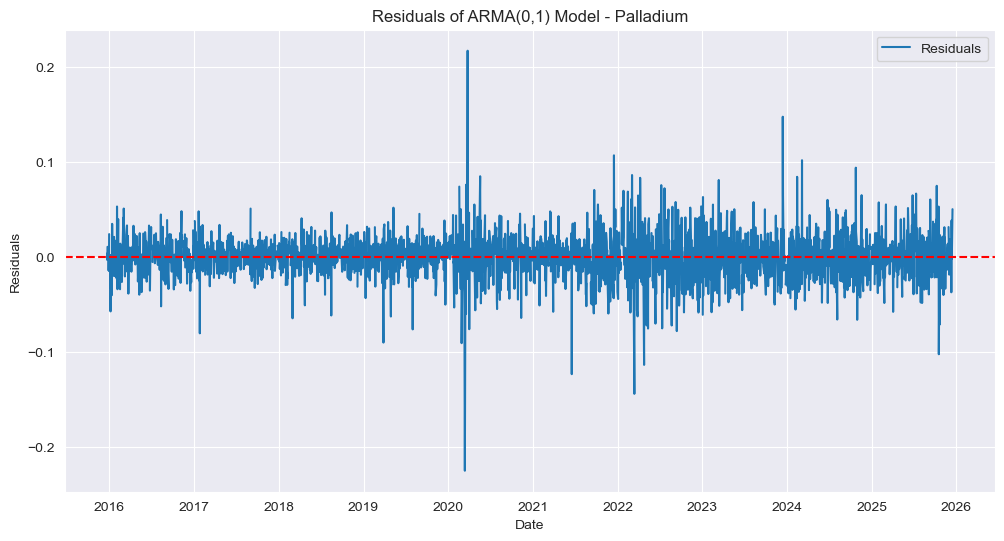

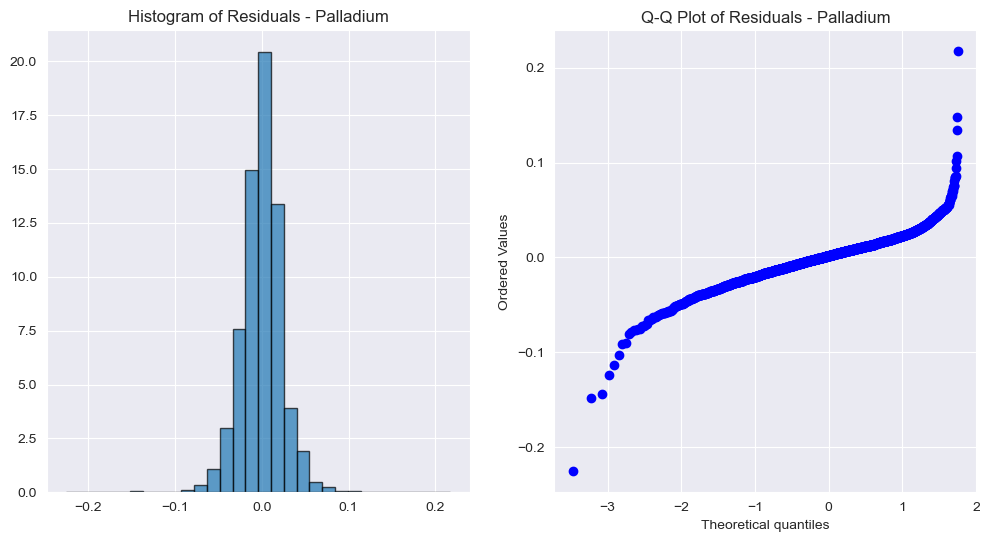

In [ ]:
# Palladium - Extract residuals
residuals_palladium = arma_best_fitted_palladium.resid

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals_palladium, label="Residuals")
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residuals of ARMA({best_p_palladium},{best_q_palladium}) Model - Palladium")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# Plot histogram and Q-Q plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Histogram
axes[0].hist(residuals_palladium, bins=30, density=True, alpha=0.7, edgecolor='black')
axes[0].set_title("Histogram of Residuals - Palladium")
# Q-Q plot
probplot(residuals_palladium, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot of Residuals - Palladium")
plt.show()


In [ ]:
# Summary table for all metals
arma_summary = pd.DataFrame([
    {
        'Metal': 'Gold',
        'Best Order': f"ARMA({best_p_gold},{best_q_gold})",
        'AIC': arma_results_df_gold.iloc[0]['AIC'],
        'BIC': arma_results_df_gold.iloc[0]['BIC']
    },
    {
        'Metal': 'Silver',
        'Best Order': f"ARMA({best_p_silver},{best_q_silver})",
        'AIC': arma_results_df_silver.iloc[0]['AIC'],
        'BIC': arma_results_df_silver.iloc[0]['BIC']
    },
    {
        'Metal': 'Platinum',
        'Best Order': f"ARMA({best_p_platinum},{best_q_platinum})",
        'AIC': arma_results_df_platinum.iloc[0]['AIC'],
        'BIC': arma_results_df_platinum.iloc[0]['BIC']
    },
    {
        'Metal': 'Palladium',
        'Best Order': f"ARMA({best_p_palladium},{best_q_palladium})",
        'AIC': arma_results_df_palladium.iloc[0]['AIC'],
        'BIC': arma_results_df_palladium.iloc[0]['BIC']
    }
])

print("\nARMA Model Selection Summary - All Metals:")
display(arma_summary)


ARMA Model Selection Summary - All Metals:


,Metal,Best Order,AIC,BIC
0,Gold,"ARMA(0,1)",-16128.071682,-16110.476118
1,Silver,"ARMA(0,2)",-12888.121728,-12864.660976
2,Platinum,"ARMA(0,2)",-13001.809438,-12978.348686
3,Palladium,"ARMA(0,1)",-11471.360865,-11453.765302
